# Data analysis of immigration data for Chile (2018)

In this notebook, the supplied immigration data is analysed. It represents all the accepted visas for Chile of the year 2018, provided by the _Servicio Nacional de Migraciones_ (Immigrations Services). It is assumed that the steps of the _0preparation.ipynb_ notebook have already been executed - namely installing all required packages and the conversion to the parquet data format.

## Packages

In a first step the used packages are loaded to be used in the notebook.

In [50]:
# Load packages
import numpy as np
import pandas as pd
import calendar
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

## Data Loading

The data in the parquet format must now be loaded into a pandas data frame.

In [2]:
# Load data
input_data = "../data/data.parquet"
df = pd.read_parquet(input_data)

A brief overview of the data frame and it's columns helps in the analysis of the underlying data.

In [3]:
# Print the data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438232 entries, 0 to 438231
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   sex          438232 non-null  object
 1   country      438232 non-null  object
 2   birthday     438231 non-null  object
 3   activity     438232 non-null  object
 4   profession   438232 non-null  object
 5   studies      438232 non-null  object
 6   community    438232 non-null  object
 7   state        438232 non-null  object
 8   region       438232 non-null  object
 9   visa_reason  438232 non-null  object
 10  year         438232 non-null  int64 
 11  month        438232 non-null  int64 
 12  age          438232 non-null  int64 
 13  imports      438232 non-null  int64 
 14  cargo        438232 non-null  int64 
dtypes: int64(5), object(10)
memory usage: 50.2+ MB


In [4]:
# Print basic statistical information about the numeric values
df.describe()

,year,month,age,imports,cargo
count,438232.0,438232.000000,438232.000000,4.382320e+05,438232.000000
mean,2018.0,7.115304,30.256476,1.149725e+06,2.503977
std,0.0,3.348738,12.387316,4.907387e+05,1.709151
min,2018.0,1.000000,0.000000,3.000010e+05,0.000000
25%,2018.0,4.000000,24.000000,7.246415e+05,1.000000
50%,2018.0,8.000000,29.000000,1.148438e+06,3.000000
75%,2018.0,10.000000,37.000000,1.575778e+06,4.000000
max,2018.0,12.000000,119.000000,1.999990e+06,23.000000


In [5]:
# See if any of the columns contains invalid data (NaN)
df.columns[df.isna().any()]

Index(['birthday'], dtype='object')

After this general overview, we can inspect each of the columns further. Most interesting at this point are the raw columns or the unique values from the column (maybe better for most of the columns).

In [ ]:
# Optional - Print one of the columns for further inspections
column_name = 'year'
df[column_name]

In [7]:
# Optional - Print unique values for one of the columns for further inspection
column_name = 'year'
df[column_name].unique()

array([2018], dtype=int64)

After the first inspection, we can see that the year column is redundant. All values of that column contain the value 2018, and it may therefore be deleted. This means that the data set indeed only contains entries for the year 2018.
On top of that, the columns' data types can be converted to categorical data. This reduces taken memory and additionally lets us query the data in new ways. Also, the values from the birthday columns can be interpreted as datetime objects which also enhances the data handling capabilities for this column.

In [3]:
# Reinterpret categories
def convert_to_category(df: pd.DataFrame, keys: list[str]) -> pd.DataFrame:
  for key in keys:
    df[key] = df[key].astype('category')
  return df

df = df.convert_dtypes()
df = convert_to_category(df,
                        ['sex', 'country', 'activity',
                         'profession', 'studies', 'community', 'state',
                         'region', 'visa_reason', 'month'])
df['birthday'] = pd.to_datetime(df['birthday'])

In [4]:
# Delete redundant year column
del df['year']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438232 entries, 0 to 438231
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   sex          438232 non-null  category      
 1   country      438232 non-null  category      
 2   birthday     438231 non-null  datetime64[ns]
 3   activity     438232 non-null  category      
 4   profession   438232 non-null  category      
 5   studies      438232 non-null  category      
 6   community    438232 non-null  category      
 7   state        438232 non-null  category      
 8   region       438232 non-null  category      
 9   visa_reason  438232 non-null  category      
 10  month        438232 non-null  category      
 11  age          438232 non-null  Int64         
 12  imports      438232 non-null  Int64         
 13  cargo        438232 non-null  Int64         
dtypes: Int64(3), category(10), datetime64[ns](1)
memory usage: 19.7 MB


This also apparently reduces the data frames size from 50.2+ MB to 19.7 MB.

In [5]:
# Translate country list
# found on https://121spanish.com/nationalities
country_df = pd.read_csv("../data/country_translations.csv", sep='\t')
del country_df['Language'], country_df['Nationality']
translation_dict = country_df.set_index('Country').to_dict()['In English']

# Some translations don't work -> we do them manually
translation_dict.update({
    'Haití':            'Haiti',
    'Líbano':           'Lebanon',
    'Nueva Zelanda':    'New Zealand',
    'Rumanía':          'Rumania',
    'Sudráfica':        'South Africa',         # Spelling mistake is actually in data
    'República De Bielorrusia': 'Belarus',
    'República De Serbia':  'Serbia',
    'República de Congo':   'Congo',
    'Otro país':        'Other Country'
})

df.country = df.country.cat.rename_categories(translation_dict)

In [6]:
# Translate sex
df.sex = df.sex.cat.rename_categories({'Femenino': 'Female', 'Masculino': 'Male'})

## Last Setups

Before plotting the data and trying to find meaningful relations, some last settings are made to the different packages to make them more suited to this use case.

In [7]:
# Configure Matplolib
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.dpi'] = 300

## Inspection of the columns

Before finding possible connections between the columns, they should each be inspected separately.

### Numerical data

First, a description for eac of the data columns is given.
After this, for each of the numerical data columns, a box plot is created and the basic statistical parameters such as the maximum, minimum, median, mean, standard deviation, the quartile separation values and the 90th quantile are printed.

#### Age

The age is, as the name suggests, the age of the immigrant at the time of immigration.

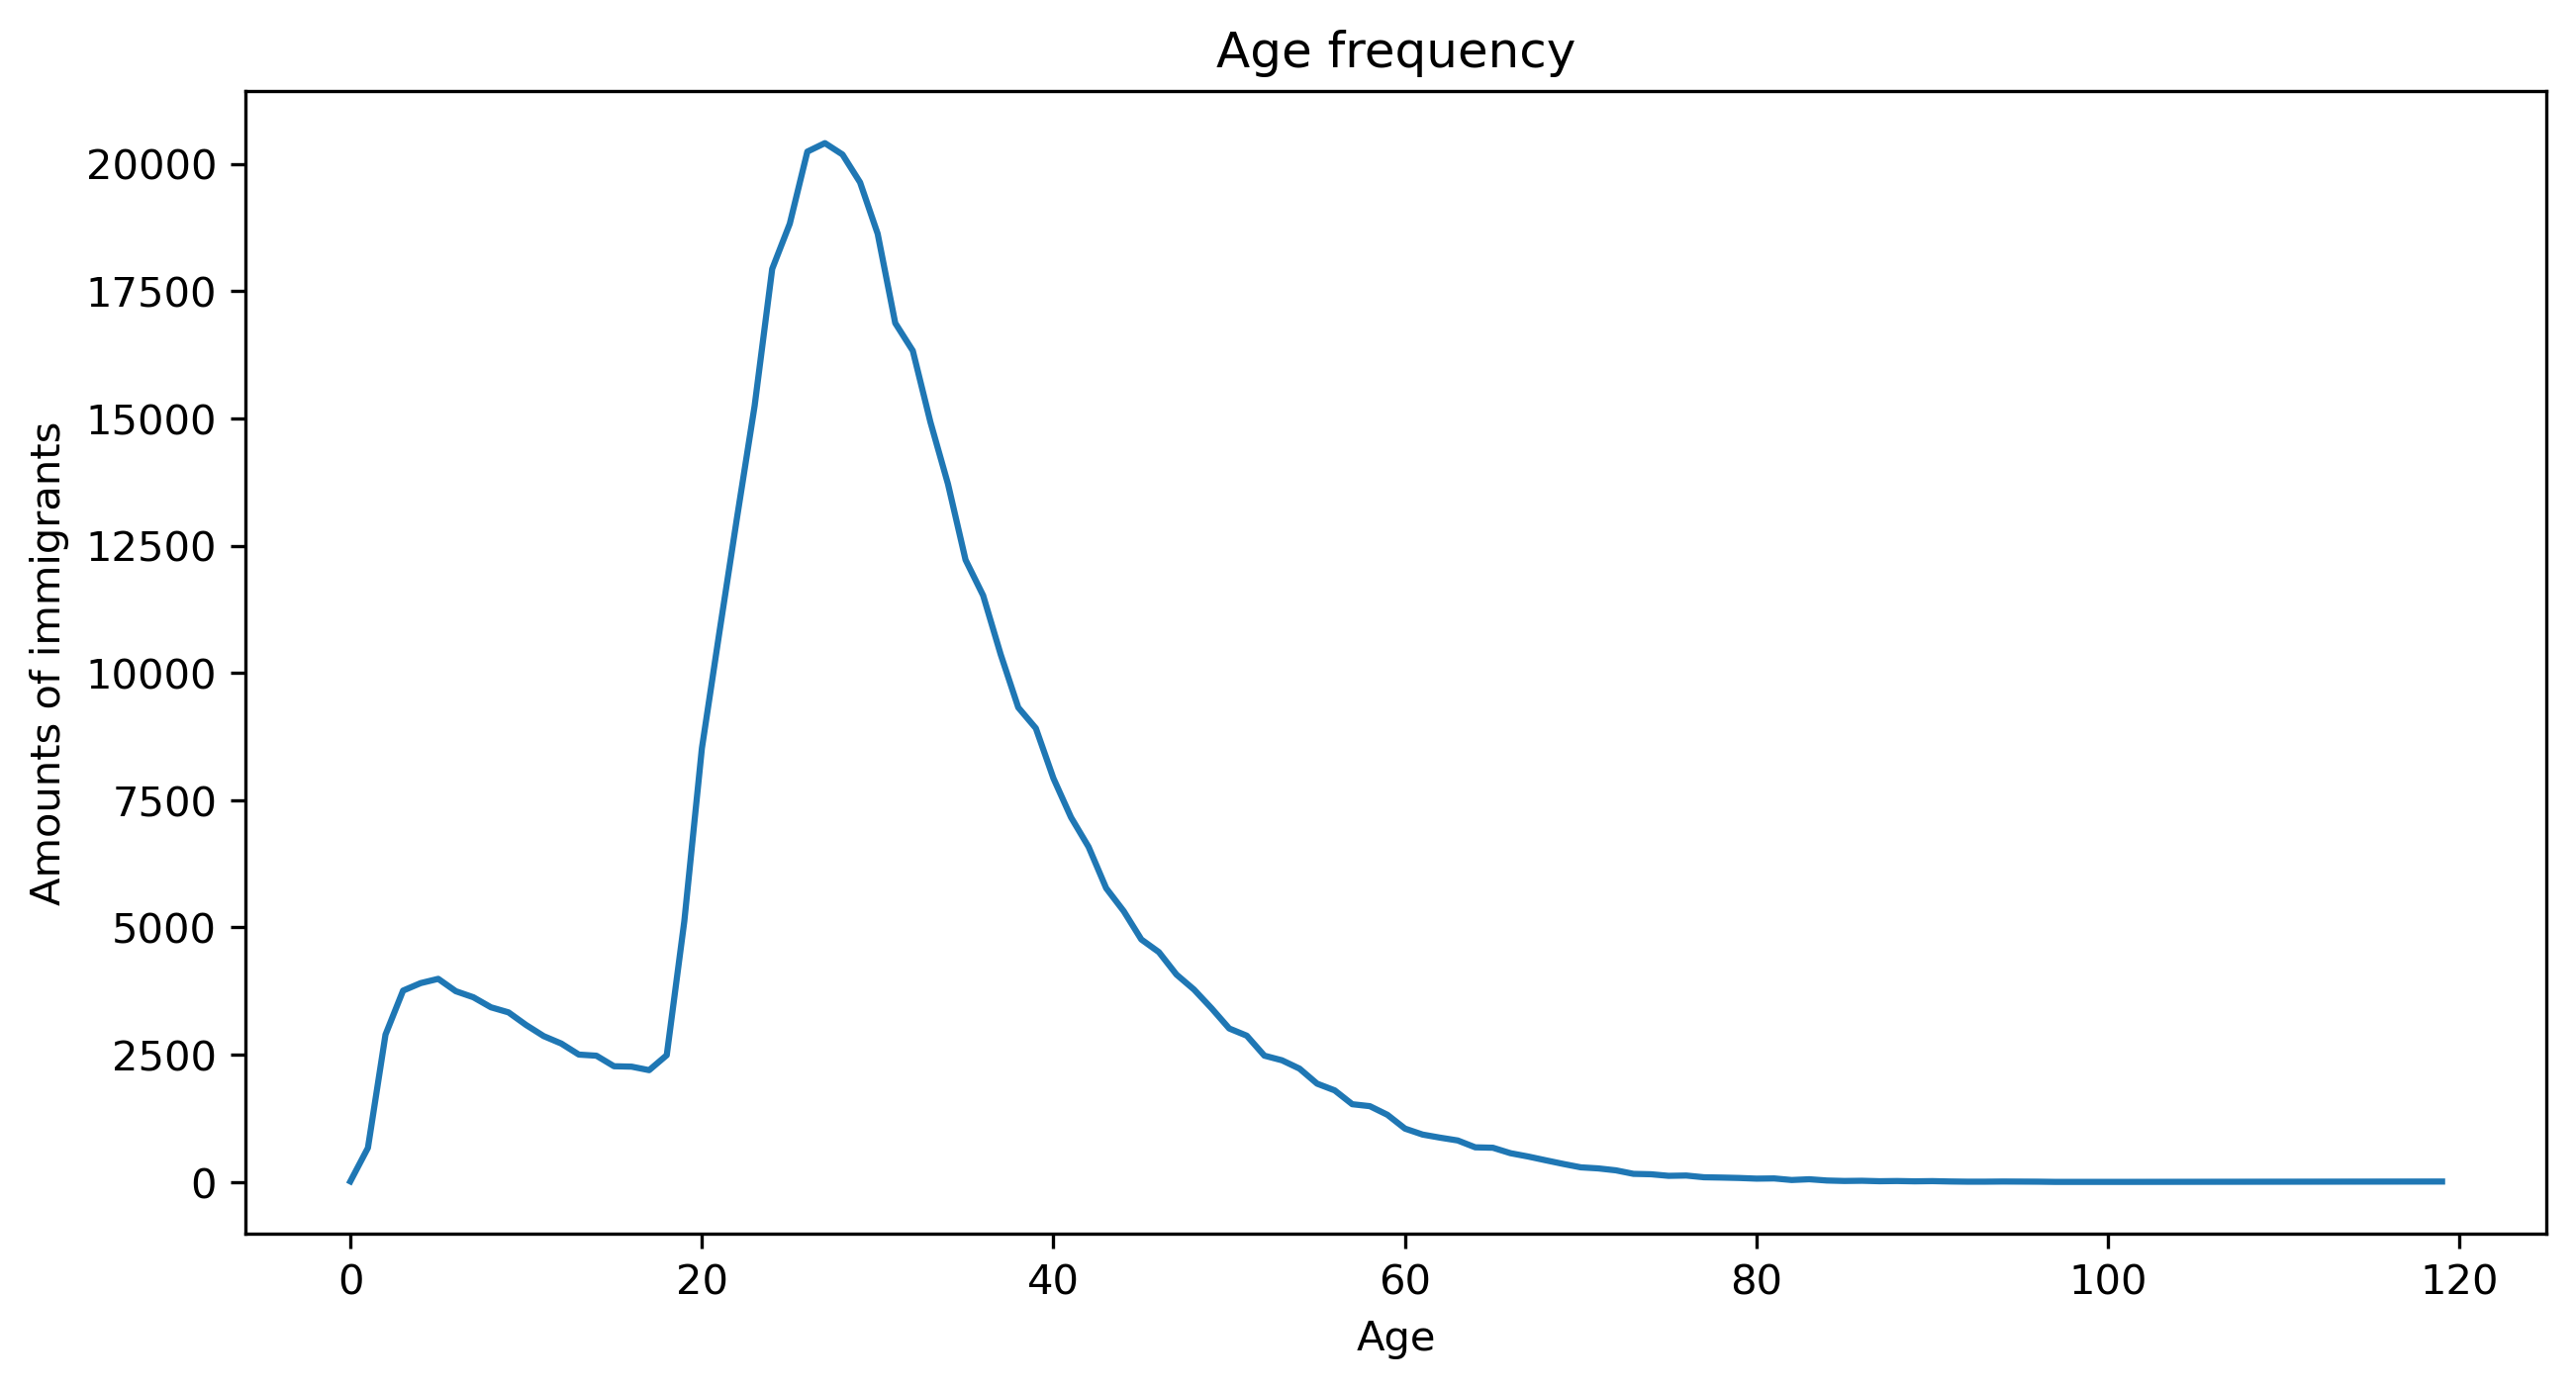

In [460]:
# Plot age frequency
df.groupby('age').size().plot.line()
plt.title("Age frequency")
plt.xlabel("Age")
plt.ylabel("Amounts of immigrants")
plt.show()

This distribution does not follow any of the rules of the most common distributions is therefore at best a combined distribution.

#### Imports

Imports represent the financial means brought into the country. They are given in Chilean Pesos (CLP).

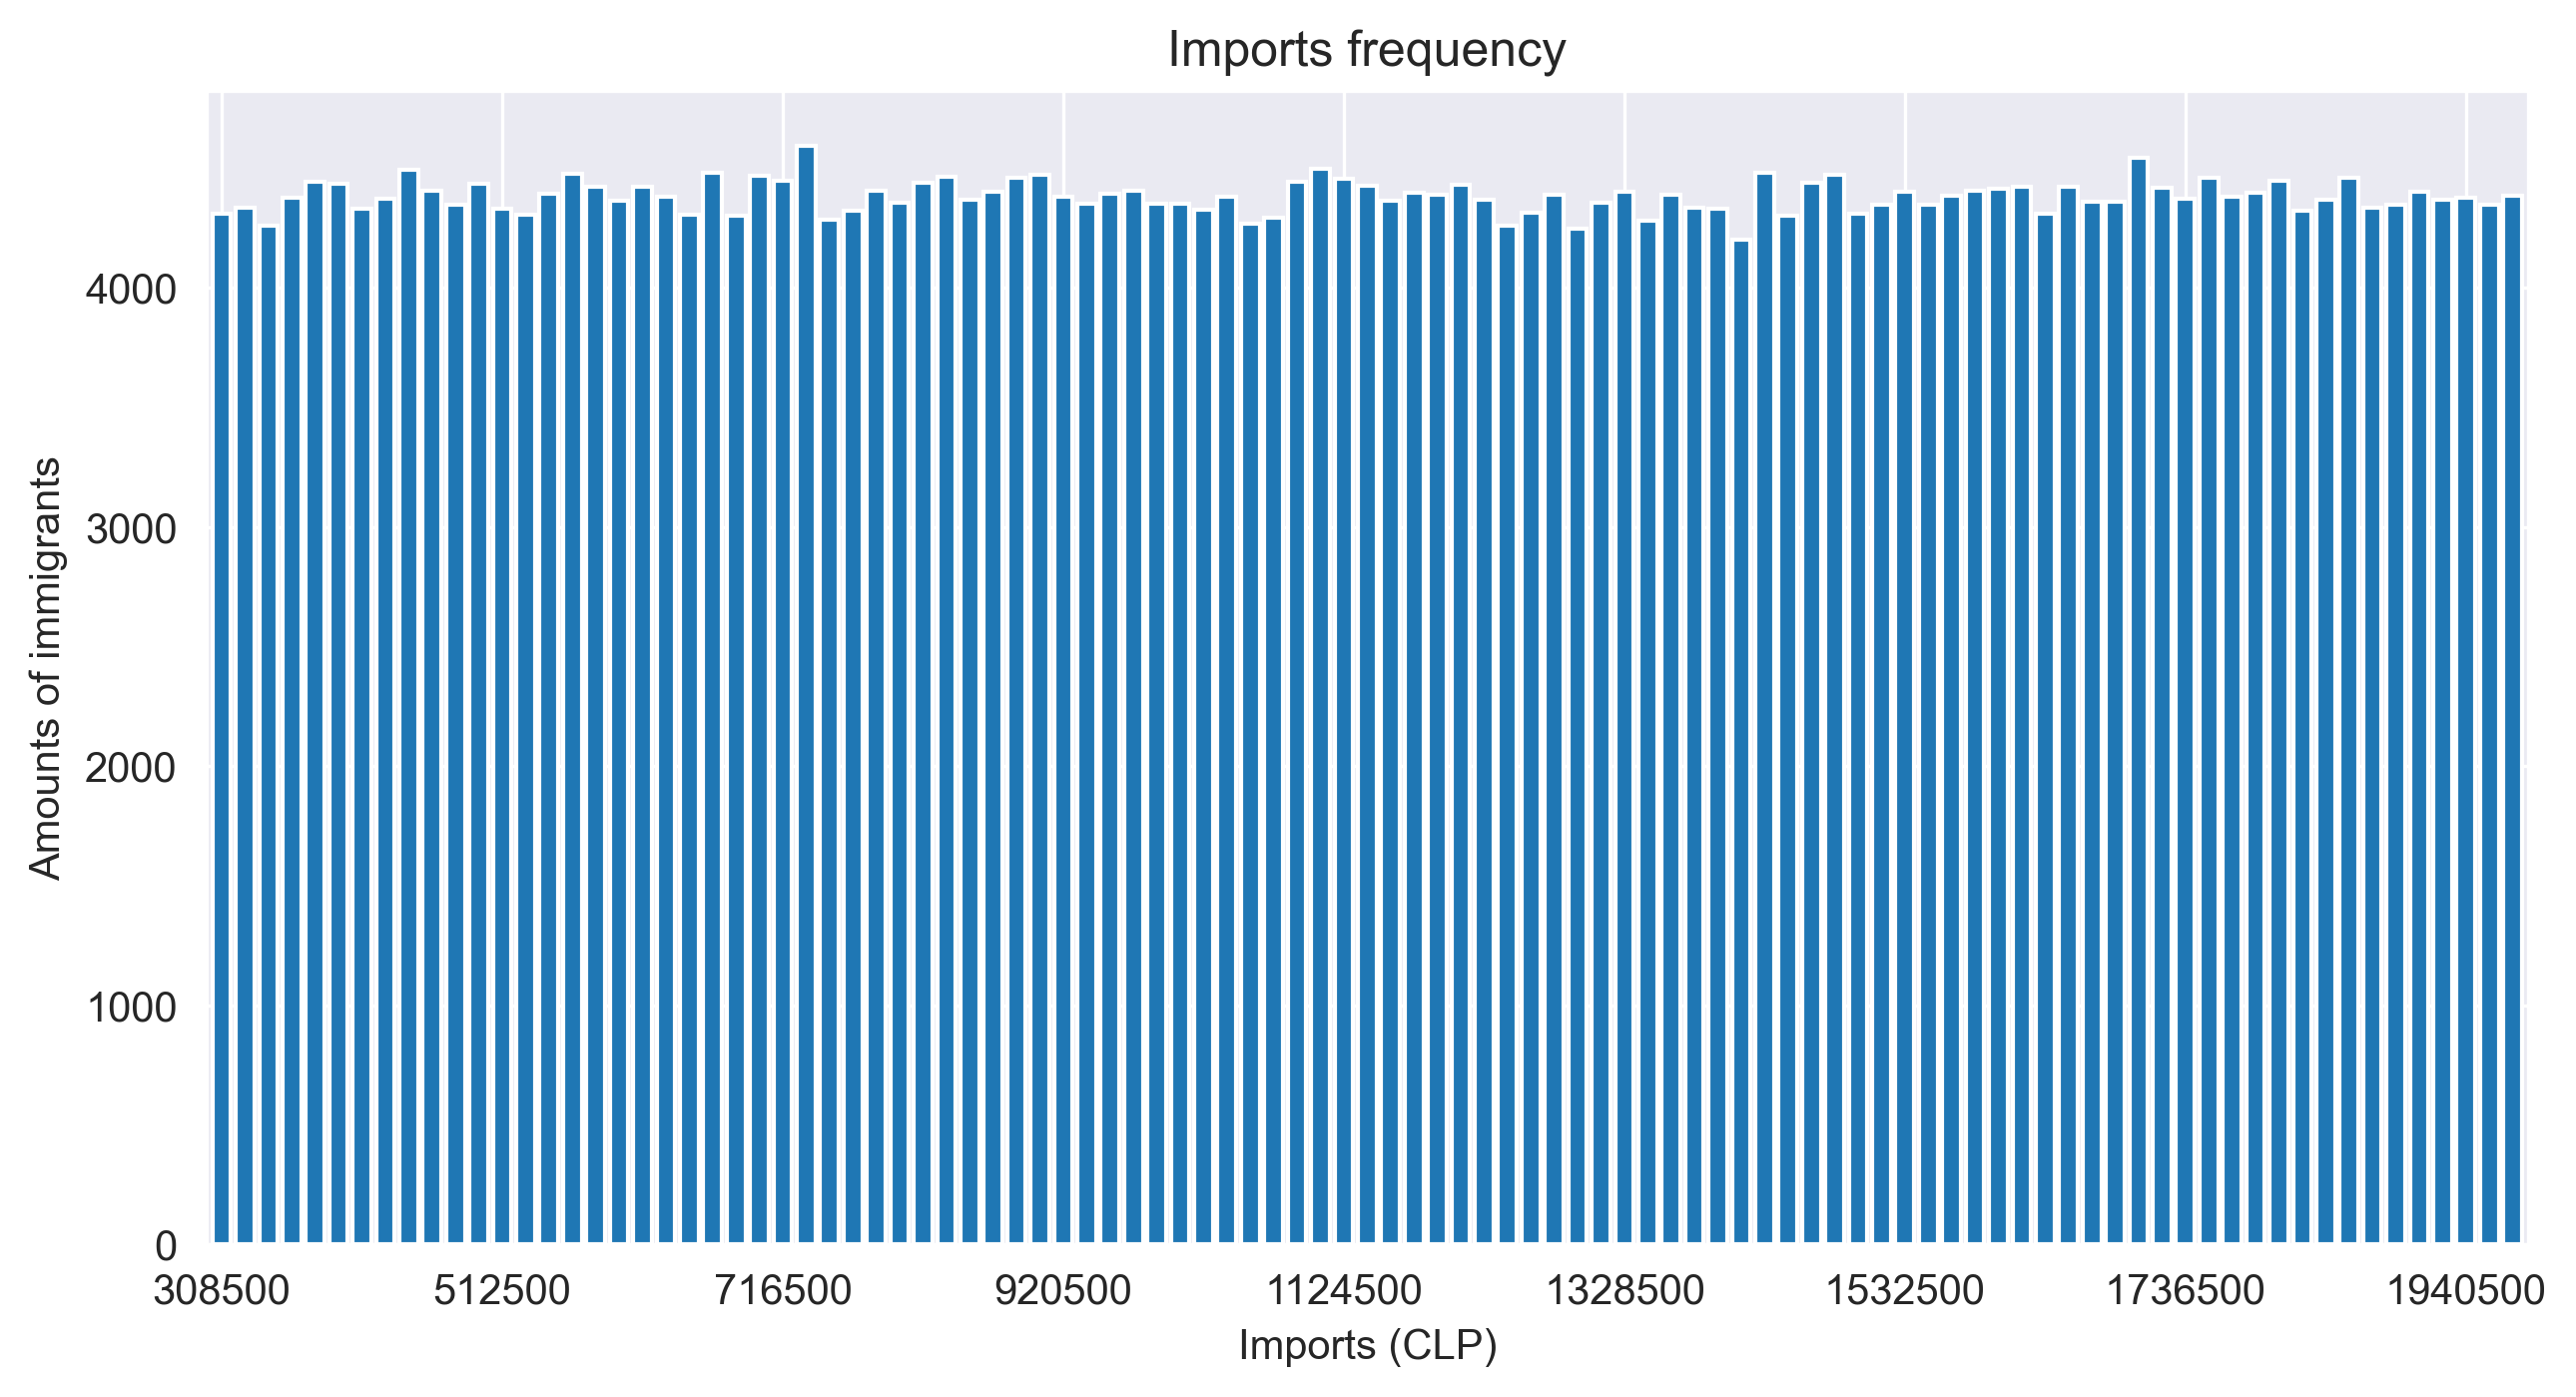

In [60]:
# Plot imports frequency
lower, higher = df['imports'].min() // 100 * 100, df['imports'].max() // 100 * 100
bin_size = 17_000
n_bins = [i for i in range(lower, higher, bin_size)]
edges = range(lower, higher, bin_size)
lbs = ['%d'%((edges[i] + edges[i+1]) / 2) for i in range(len(edges)-1)]

pd.cut(df['imports'], bins=n_bins, labels=lbs, include_lowest=True)\
    .value_counts()\
    .sort_index()\
    .plot.bar(align='center', width=.8)

plt.xticks(range(0, len(lbs) + 1, len(lbs) // 8), rotation=0)

plt.title("Imports frequency")
plt.xlabel("Imports (CLP)")
plt.ylabel("Amounts of immigrants")
plt.show()

Apart from minor deviations, this data follows closely a uniform distribution.

#### Cargo

The cargo represents the loads brought to Chile when immigrating.

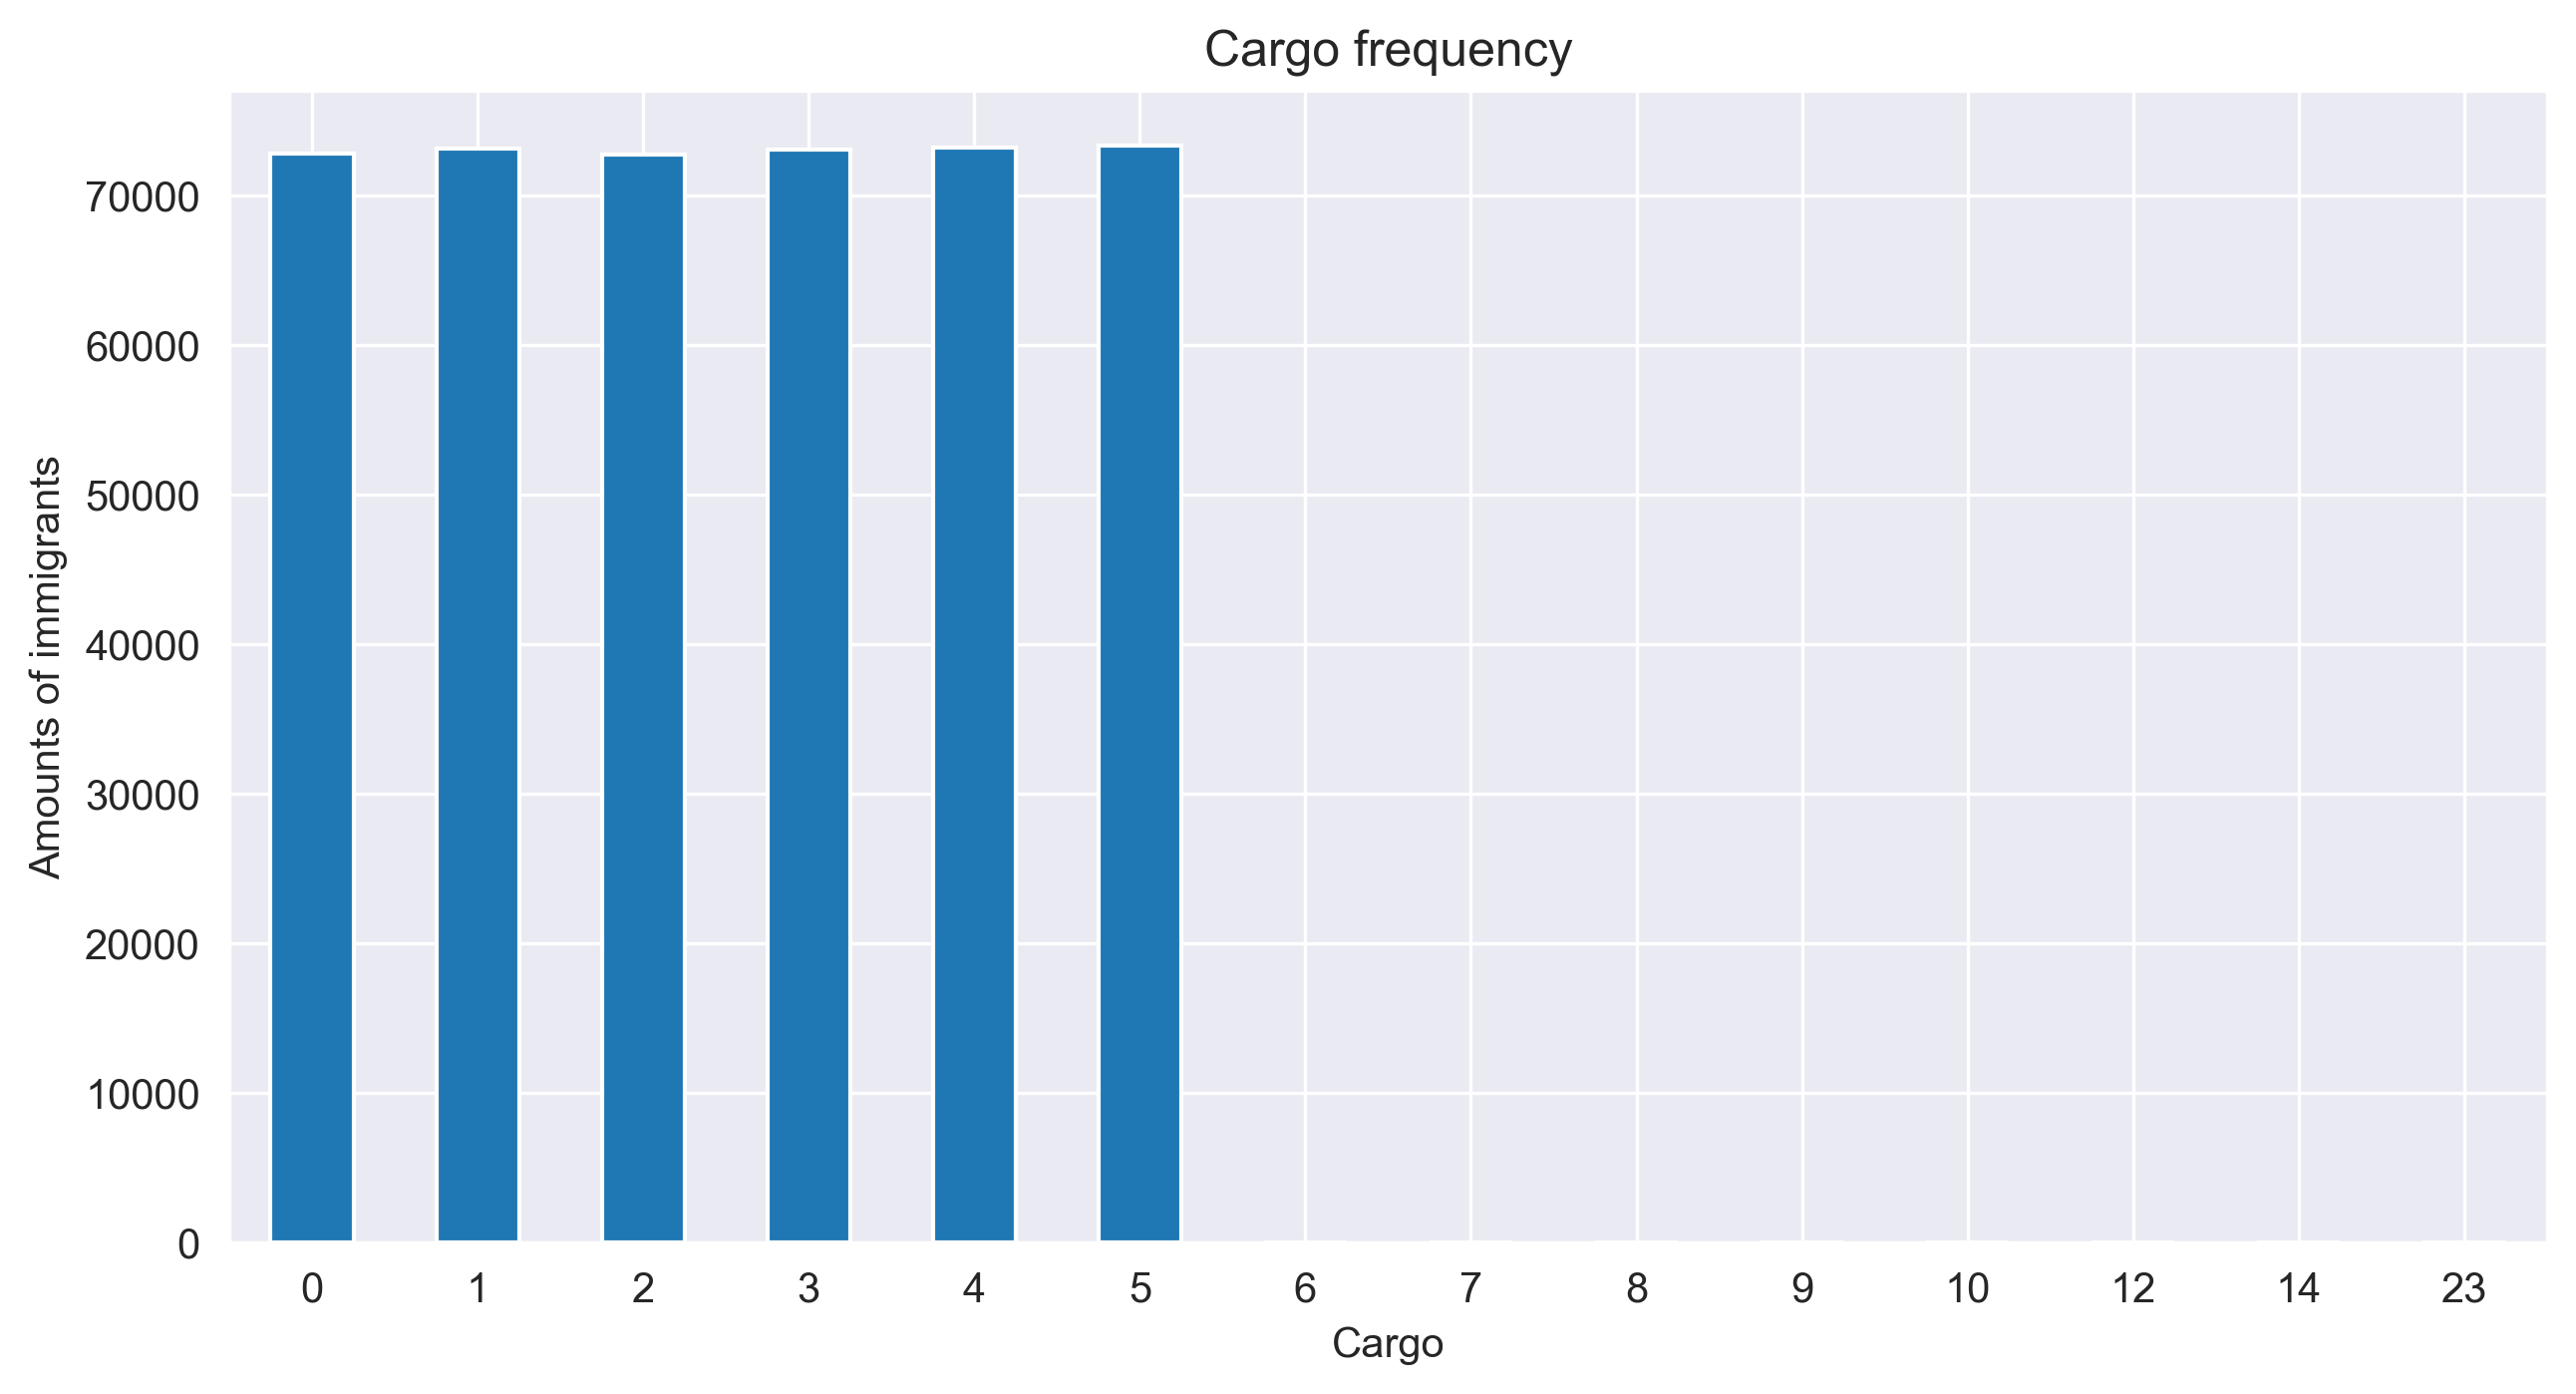

In [71]:
# Plot cargo frequency
df.groupby('cargo').size().plot.bar()
plt.title("Cargo frequency")
plt.xticks(rotation=0)
plt.xlabel("Cargo")
plt.ylabel("Amounts of immigrants")
plt.show()

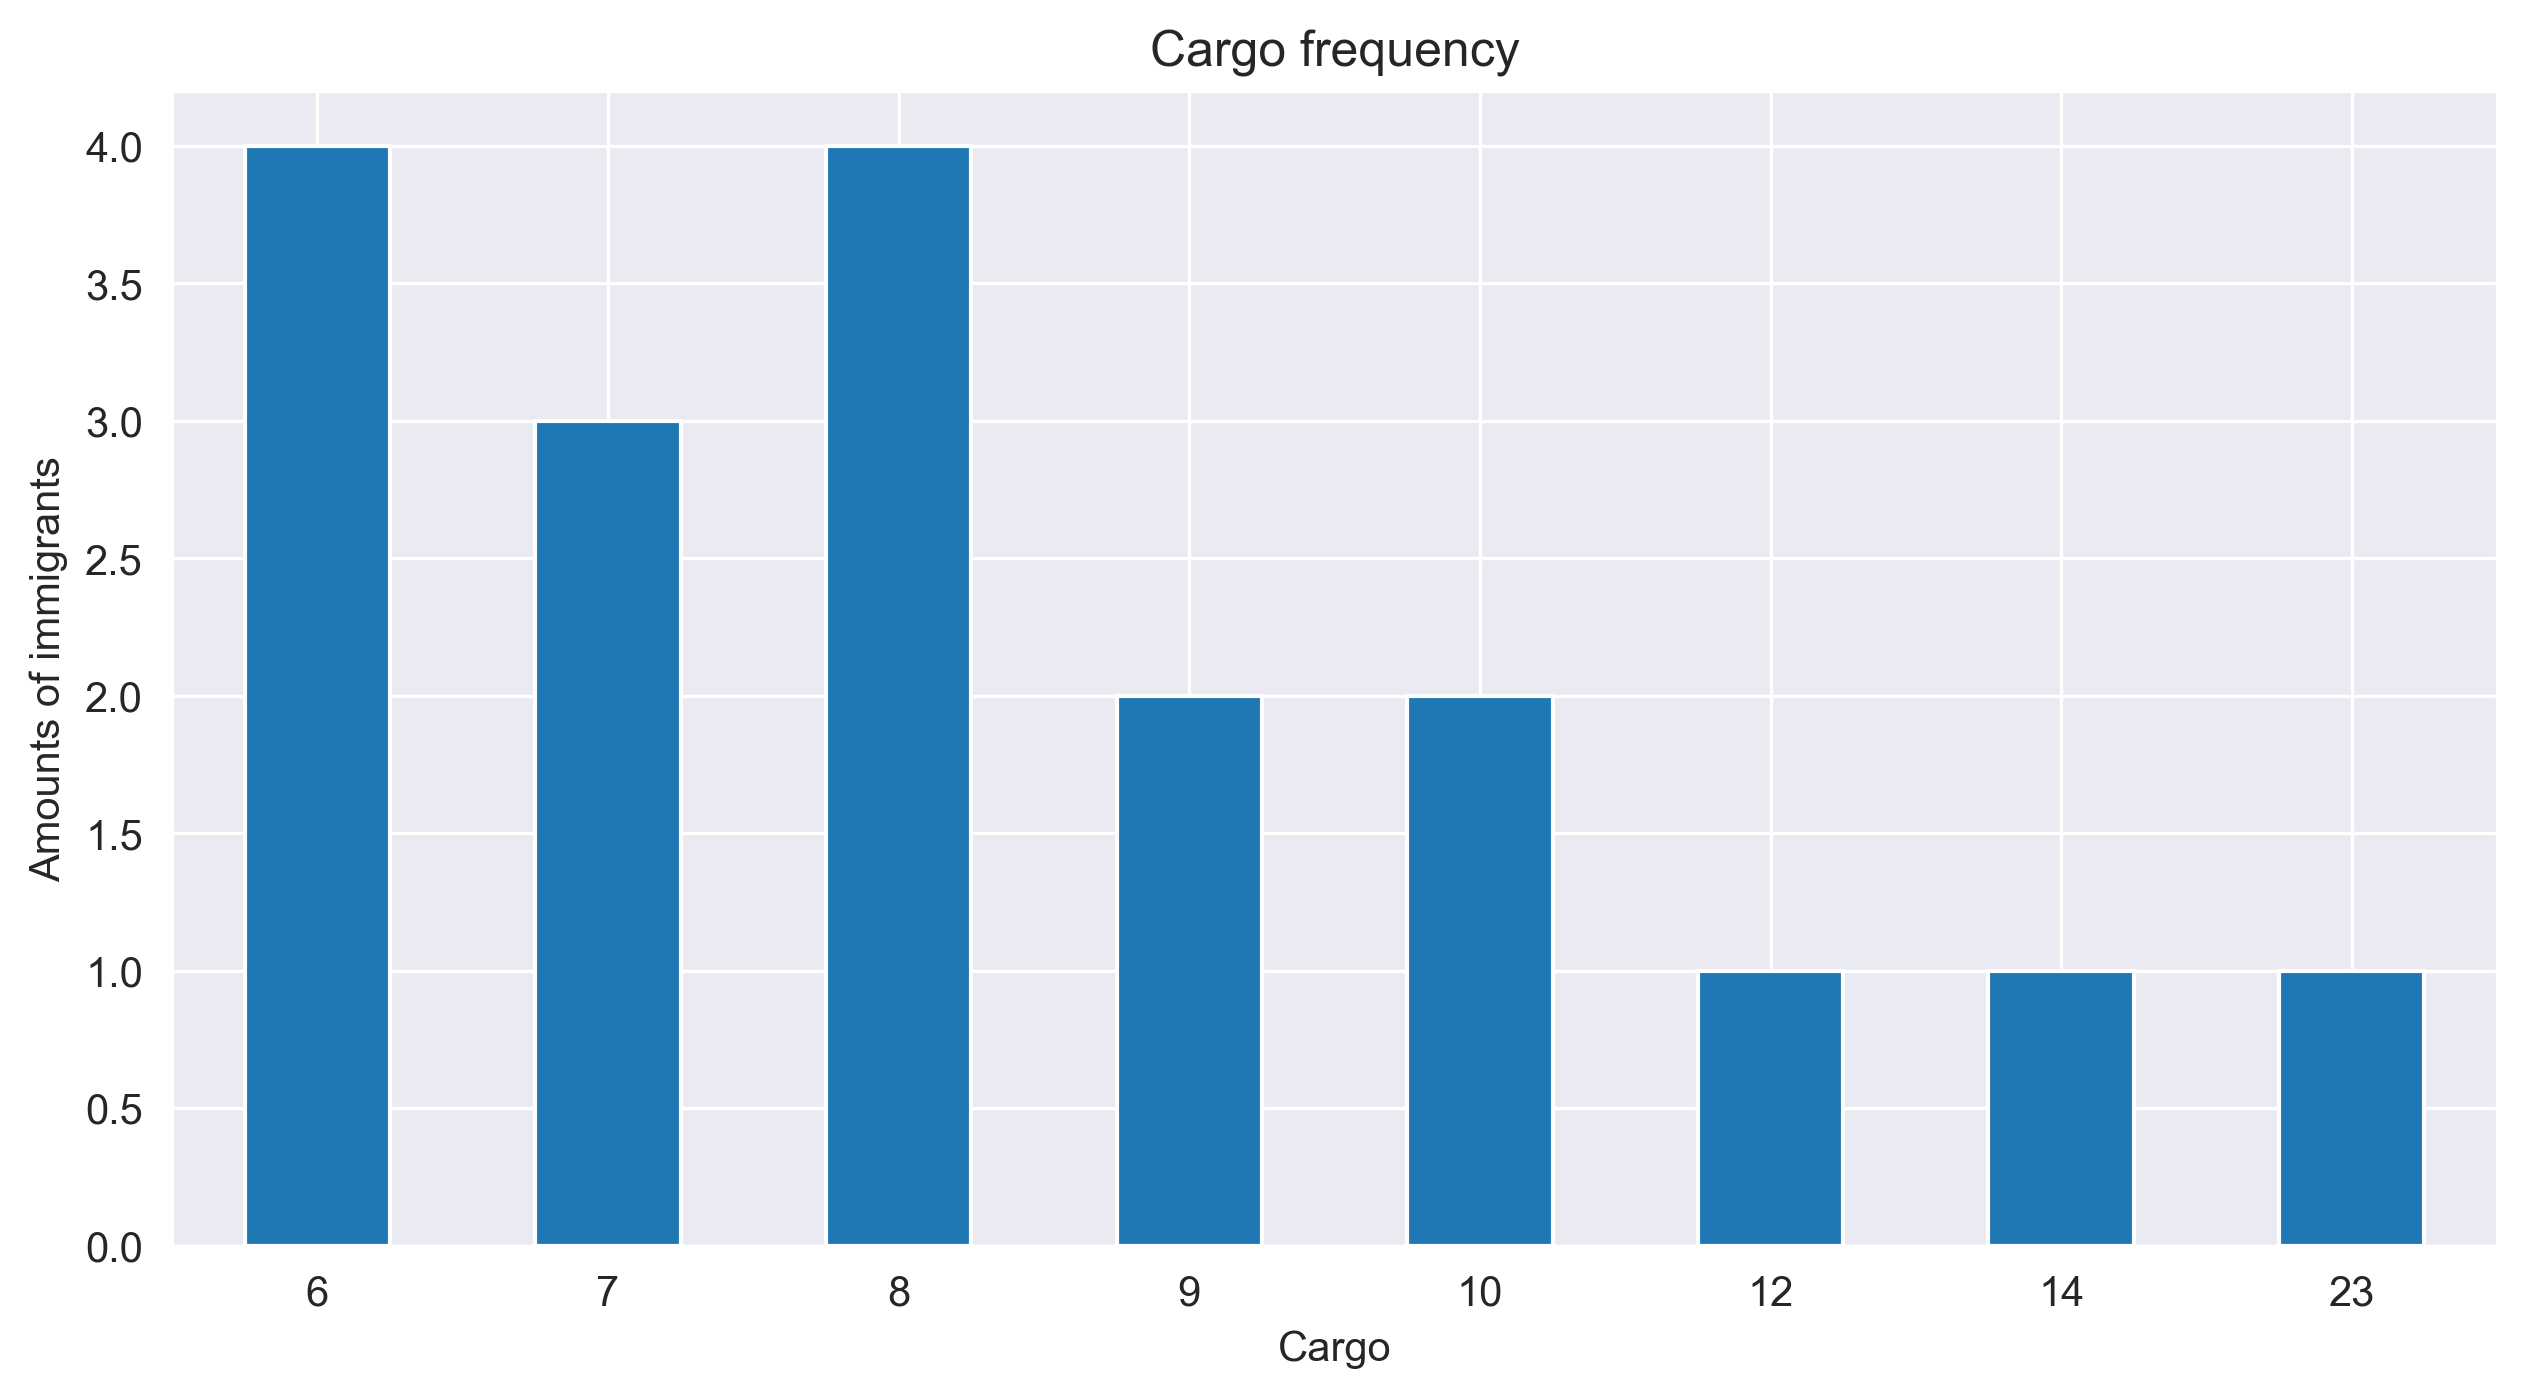

In [76]:
# Plot cargo frequency outliers
sized = df.groupby('cargo').size()
sized[sized.index > 5].plot.bar()
plt.title("Cargo frequency of outliers (>5)")
plt.xticks(rotation=0)
plt.xlabel("Cargo")
plt.ylabel("Amounts of immigrants")
plt.show()

While up to 5 cargos, the data seems to follow a uniform distribution, beginning with 6 cargos, there are only less than 5 immigrants for each of the different cargo counts (18 total). This might be due to laws special fees for 5 cargos and more, however, no solid explanation could be identified.

#### Box plots

To save some space, the 3 box plots are plotted next to each other.

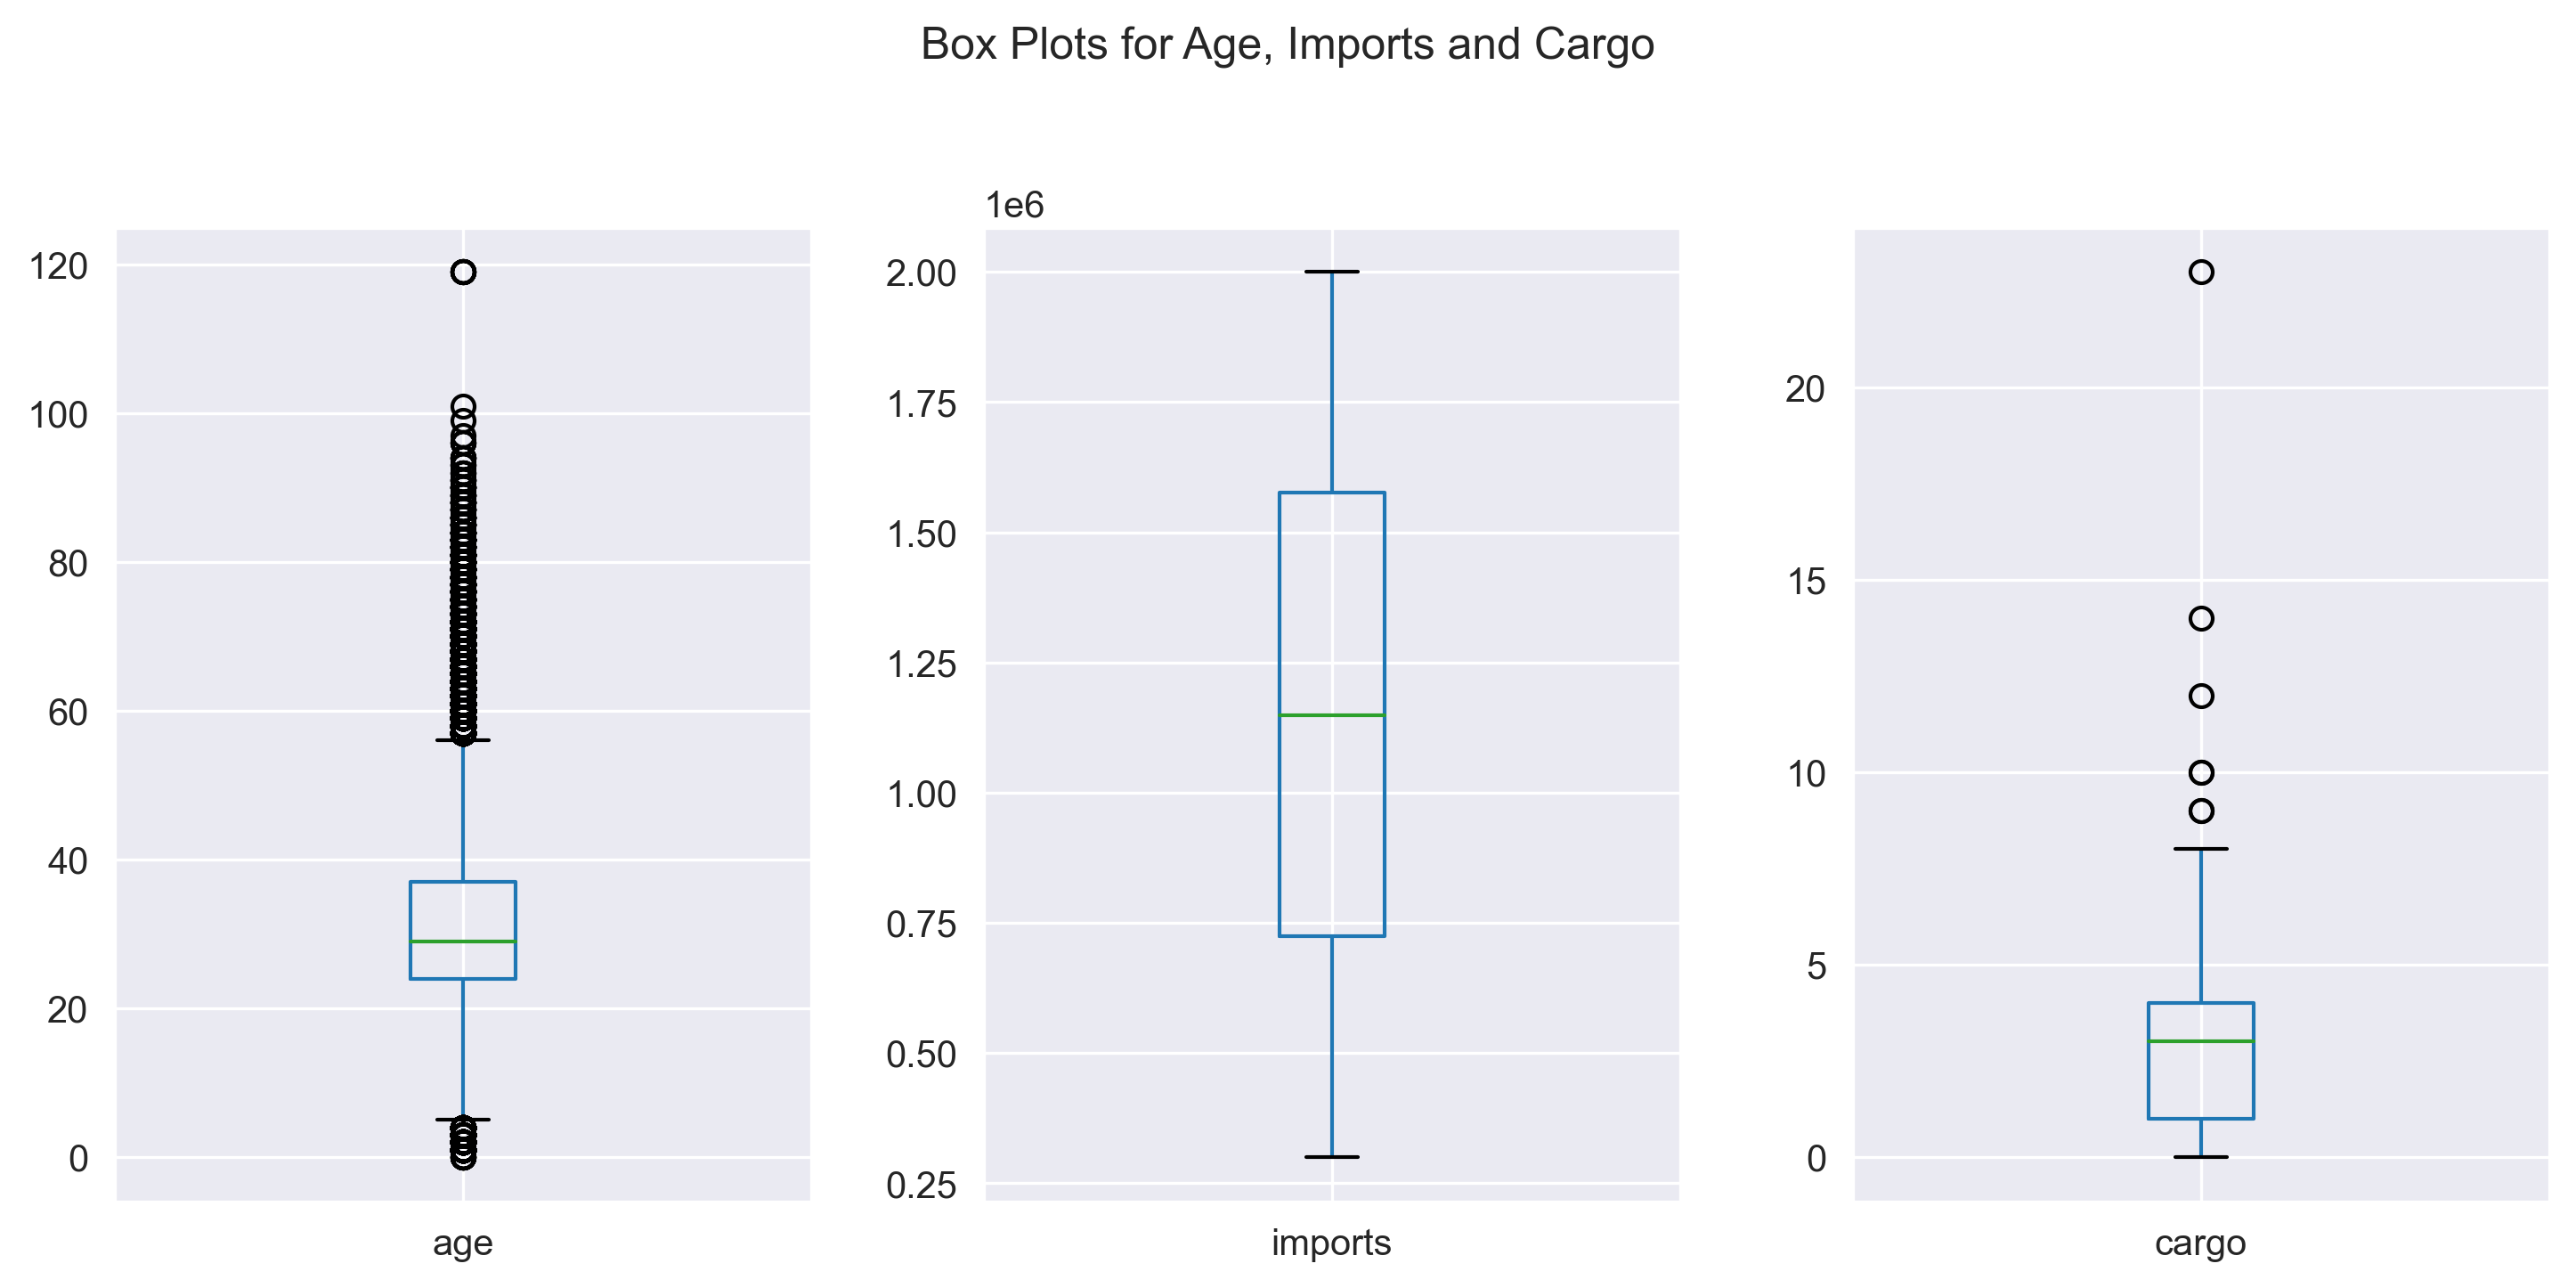

In [77]:
# Create box plot
fig, axs = plt.subplots(1, 3)

df.boxplot(column='age', ax=axs[0])
df.boxplot(column='imports', ax=axs[1])
df.boxplot(column='cargo', ax=axs[2])

fig.suptitle("Box Plots for Age, Imports and Cargo")
fig.tight_layout(pad=2.0)

plt.show()

#### Statistical Parameters

The statistical parameters for the numerical data are created and put into a separate data frame and then printed in table form.

In [88]:
# Create and Print statistical parameters
def create_quant(quantile: float) -> callable:
    def quant(x):
        return x.quantile(quantile)
    quant.__name__ = f"{int(quantile * 100)}%"
    return quant

interesting_parameters = [
    'max',
    'min',
    'median',
    'mean',
    'std',
    'skew',
    create_quant(0.25),
    create_quant(0.5),
    create_quant(0.75),
    create_quant(0.9)
]

df.aggregate({'age': interesting_parameters, 'imports': interesting_parameters, 'cargo': interesting_parameters}).T

,max,min,median,mean,std,skew,25%,50%,75%,90%
age,119.0,0.0,29.0,3.025648e+01,12.387316,0.342909,24.0,29.0,37.00,46.0
imports,1999990.0,300001.0,1148437.5,1.149725e+06,490738.702397,0.002184,724641.5,1148437.5,1575778.25,1829627.0
cargo,23.0,0.0,3.0,2.503977e+00,1.709151,0.003164,1.0,3.0,4.00,5.0


### Categorical data

The columns of the data frame containing categorical data cannot be interpreted as the numerical data in that sense that the statistical parameters are not defined by default. Therefore, we use the frequency of the categories of the category columns for analysing.

#### Sex

This column represents the biological gender of the immigrants coming to Chile. The values can either be _male_ (masculino) or _female_ (feminino).

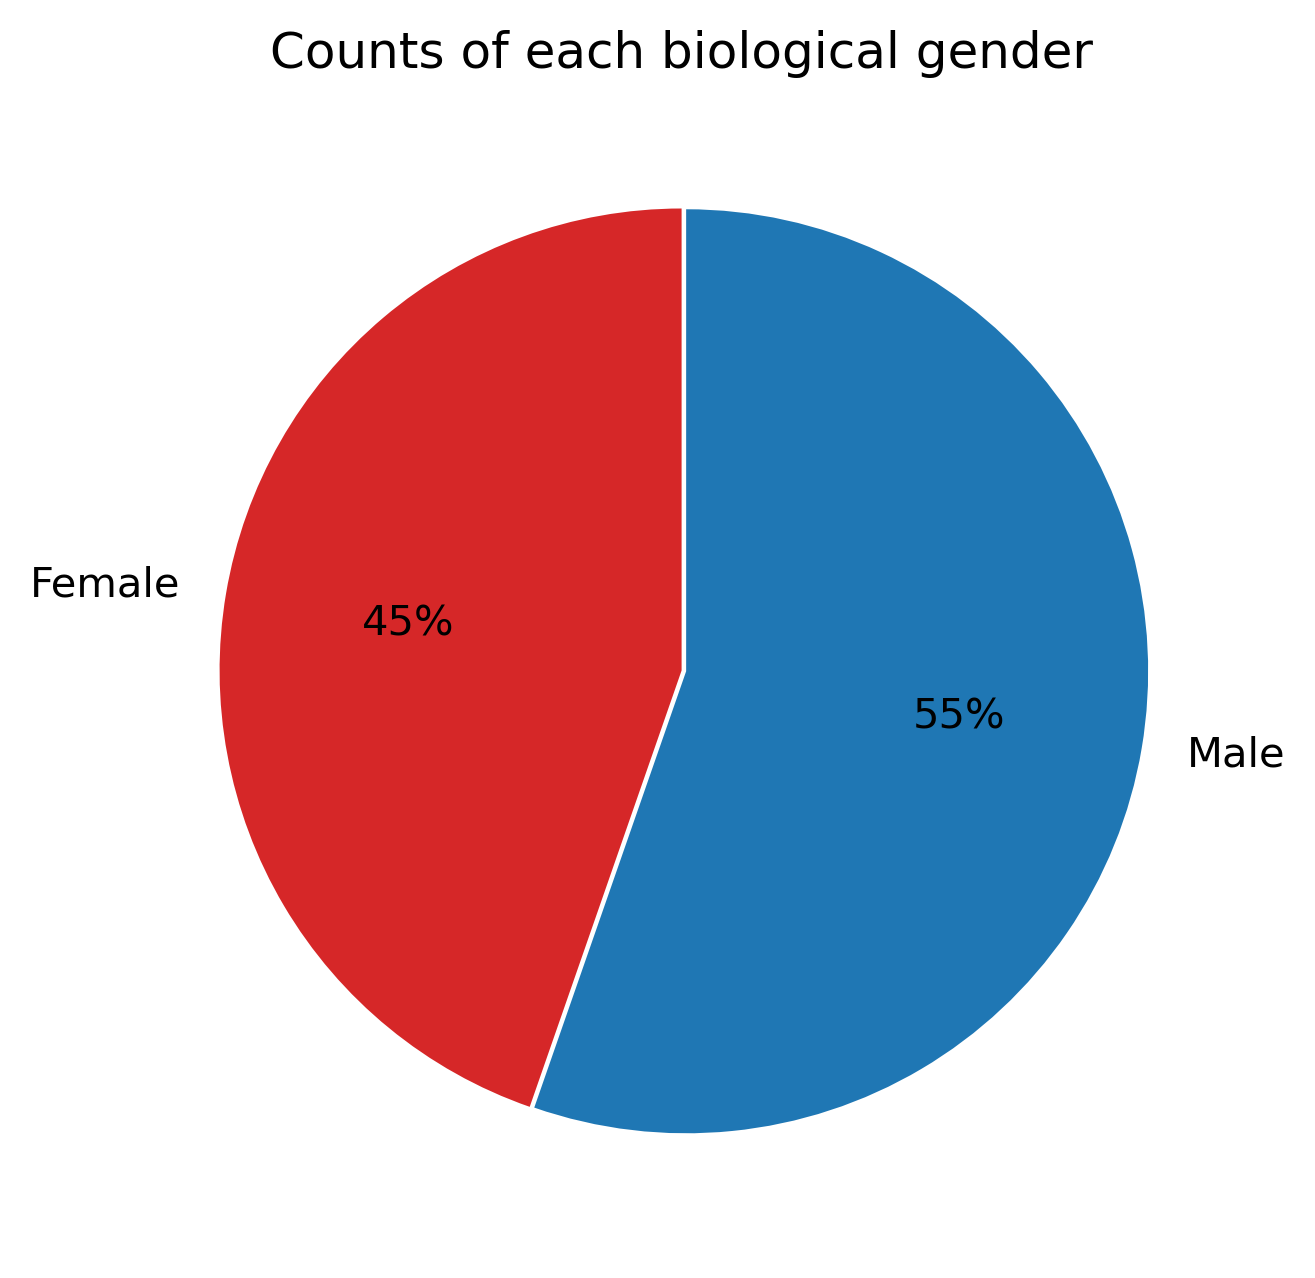

In [455]:
# Creates bar plot for frequency of male and female immigrants
df.groupby('sex').size().plot.pie(startangle=90, colors=['tab:red', 'tab:blue'], autopct='%1.f%%', explode=(0, 0.01))
#ax = sns.countplot(x=df.sex, palette=['tab:red', 'tab:blue'])
plt.title("Biological genders of immigrants")
plt.show()

In [186]:
# Print statistical information about sex
sex_size = df.groupby(['sex']).size()
sex_size['Total'] = len(df)
sex_size

sex
Female    195754
Male      242478
Total     438232
dtype: int64

#### Country

The country column represents the country of origin for the immigrants coming to Chile. Plotting for all home countries reveals that the frequency of immigrants for a certain country differs heavily. Therefore, a log scale is more appropriate than a linear scale.

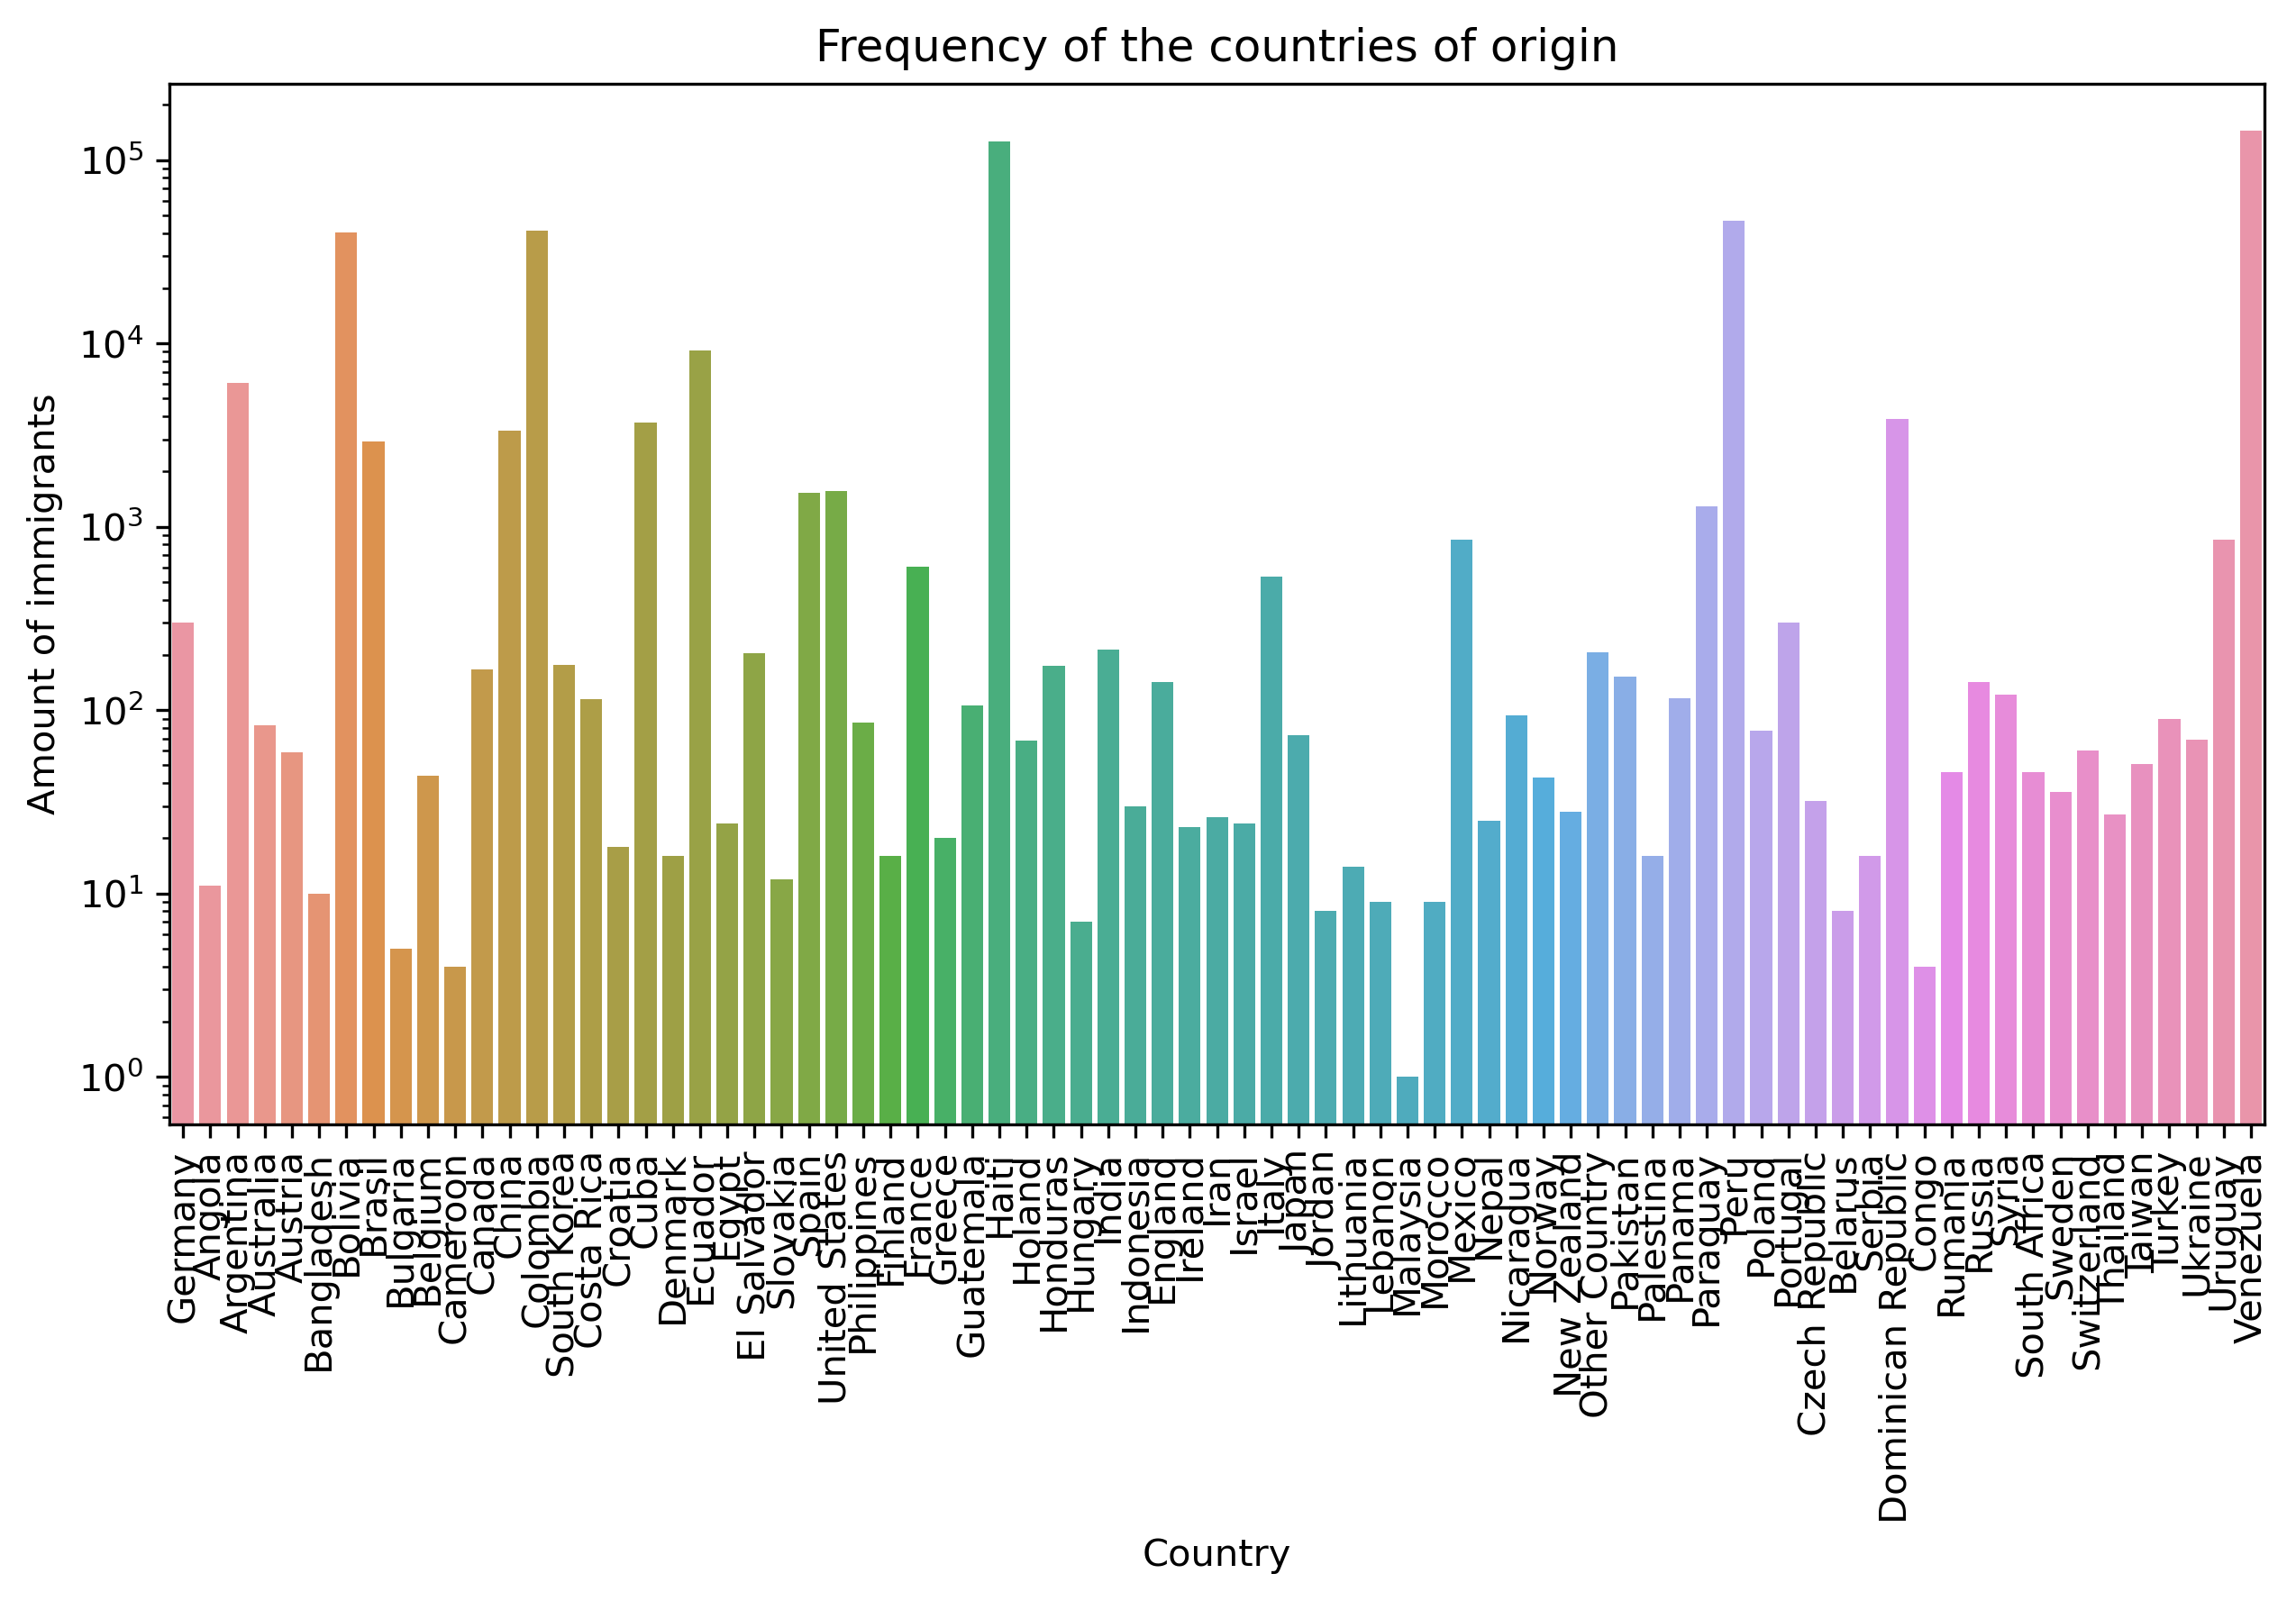

In [456]:
# Create frequency bar plot for the countries
ax = sns.countplot(x=df.country)
plt.title("Frequency of the countries of origin")
plt.xlabel("Country")
plt.ylabel("Amount of immigrants")
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

In [193]:
# Print absolute frequencies
country_size = df.groupby(['country']).size()
country_size['Countries Combined'] = len(df)
country_size

country
Germany                  302
Angola                    11
Argentina               6078
Australia                 83
Austria                   59
                       ...  
Turkey                    90
Ukraine                   69
Uruguay                  849
Venezuela             144083
Countries Combined    438232
Length: 78, dtype: int64

Most of the immigrants coming to Chile are also from South American countries. Especially high are the numbers for Venezuela and Haiti, although there are also many people coming from Peru, Colombia and Bolivia. Due to the economic strength of Chile, it seems to attract many people from the surrounding countries. For Asian or African countries, Chile does not seem very attractive though, as there are countries with higher economic stability either geographically closer or easier to reach.

#### Activity

This column describes the employment status, which might be relevant for the visa acceptance.

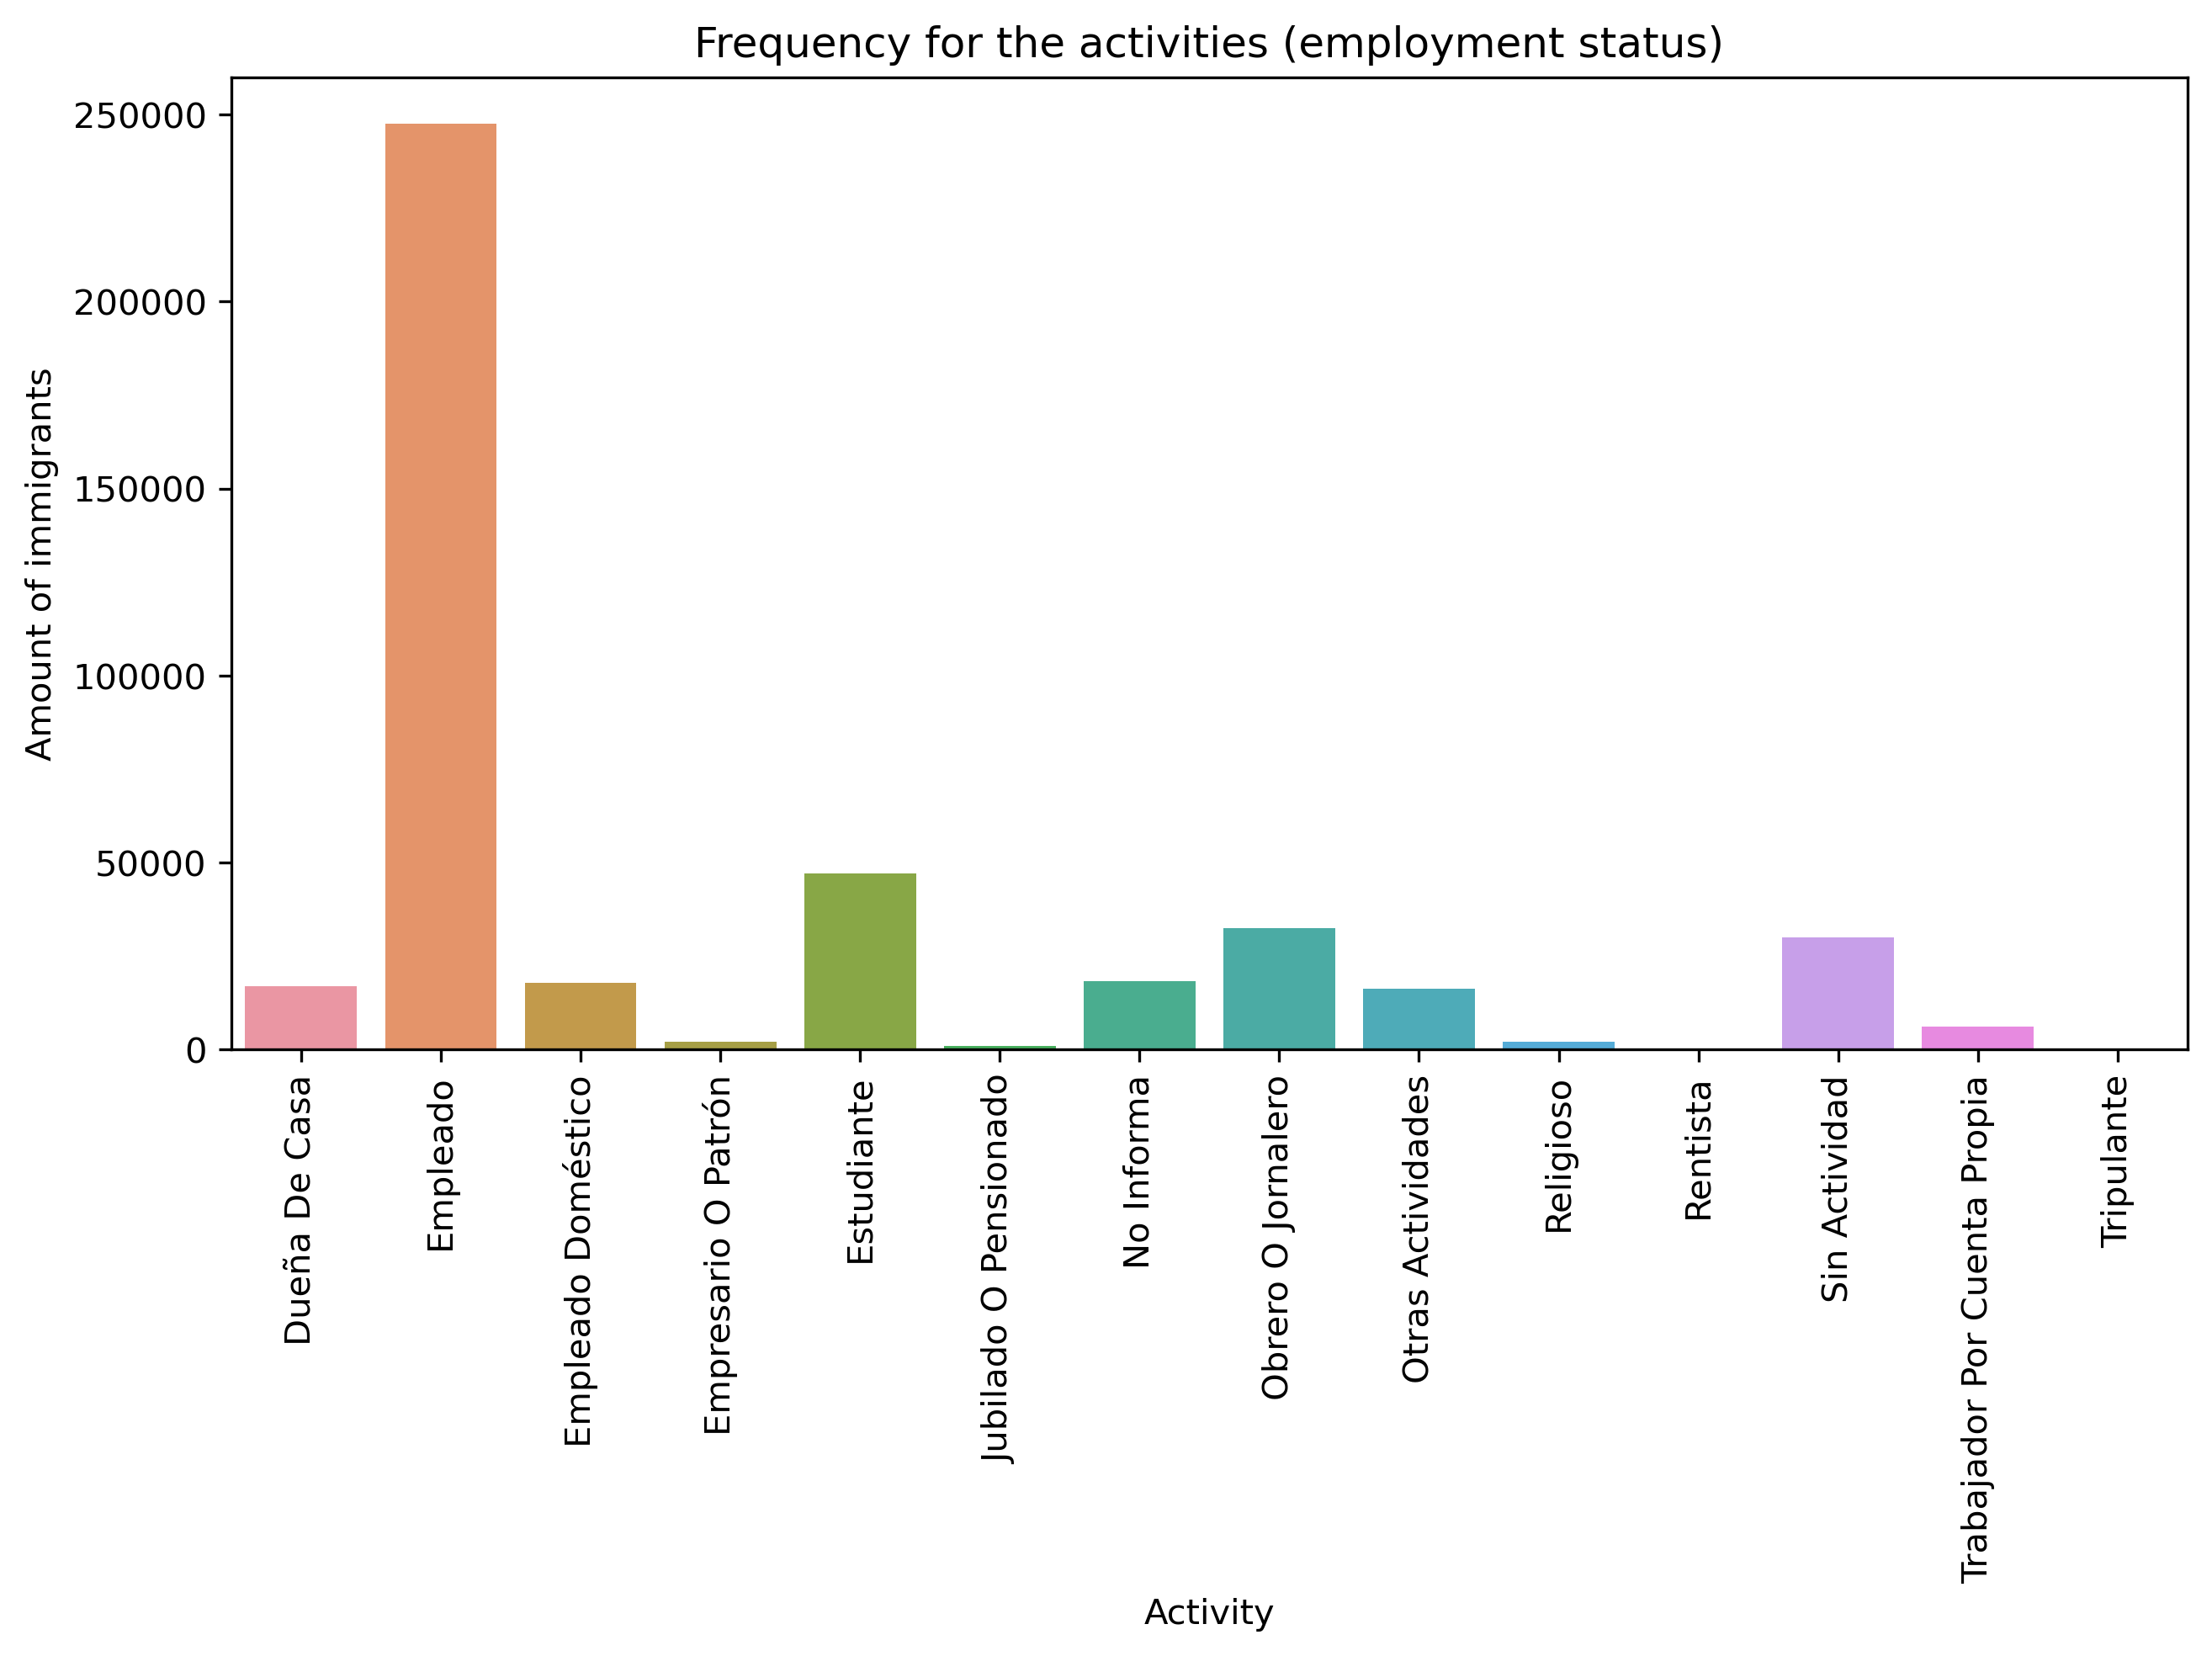

In [205]:
# Create frequency bar plot for the activities
ax = sns.countplot(x=df.activity)
plt.title("Frequency of the activities (employment status)")
plt.xlabel("Activity")
plt.ylabel("Amount of immigrants")
plt.xticks(rotation=90)
# plt.yscale('log')     # might not seem that useful at first, but helps to see the distributions
plt.show()

In [202]:
# Print absolute frequencies
activity_size = df.groupby(['activity']).size()
activity_size['total'] = len(df)
activity_size

activity
Dueña De Casa                    17066
Empleado                        247477
Empleado Doméstico               17936
Empresario O Patrón               2122
Estudiante                       47119
Jubilado O Pensionado              887
No Informa                       18330
Obrero O Jornalero               32406
Otras Actividades                16224
Religioso                         2045
Rentista                            86
Sin Actividad                    30038
Trabajador Por Cuenta Propia      6280
Tripulante                         216
total                           438232
dtype: int64

Apparently, most of the immigrants are employed. Only ~6.9%-11.0% (big range due to 18330 cases without further information) of all immigrants are unemployed.
If we assume a constant distribution, which also holds for the cases without further details, ~7.2% of the immigrants are unemployed.

#### Profession

The data set separates between 636 different professions. Therefore, a qualitative differentiation between each of those is not feasible for a general first inspection. This is why it is only important to get a general overview over the frequencies, first. This is done by printing the first ten and last ten entries based on their frequencies and the mean, median, standard deviation, min and max value of all frequencies. This helps to evaluate if a further inspection in the future might be useful.

In [255]:
# Print stats about frequencies
df.groupby('profession').size().aggregate(['mean', 'median', 'std', 'min', 'max'])

mean        689.044025
median       19.000000
std        3335.862545
min           1.000000
max       55522.000000
dtype: float64

In [254]:
# Also interesting to see the data in a log scaled fashion to get rid of some 'outlier' effects
df.groupby('profession').size().apply(np.log).aggregate(['mean', 'median', 'std', 'min', 'max'])

mean       3.307225
median     2.944439
std        2.435550
min        0.000000
max       10.924535
dtype: float64

In [235]:
# Print the 10 most frequent elements
profession_size = df.groupby('profession').size()

profession_freq = np.sort(profession_size.to_numpy())
profession_size[profession_size.isin(profession_freq[-10:])].sort_values(ascending=False)

profession
Empleado             55522
Estudiante           32913
Menor De Edad        23134
Asesora Del Hogar    18919
Obrero               18610
Sin Profesion        17919
No Informa           14759
Vendedor             14656
Dueña De Casa        13979
Ayudante             13922
dtype: int64

In [236]:
# Print the 10 least frequent elements (needs 10 most frequent elements already executed)
profession_size[profession_size.isin(profession_freq[:10])].sort_values()

profession
Accionista                1
Museologa Especialista    1
Radiodifusor              1
Puericultora              1
Pretesico Dental          1
                         ..
Ferroviario               1
Floricultor               1
Gamagrafia                1
Georafo                   1
Viticulturista            1
Length: 69, dtype: int64

We see many of the jobs are only represented once, this would make a further exploration unuseful (filtering exactly 10 values even failed in this simplified case).

#### Studies

This column represents the educational level of each of the immigrants. As they are seperated in only 7 different categories (1 being _not further specified_) also a histogram plot can be made again.

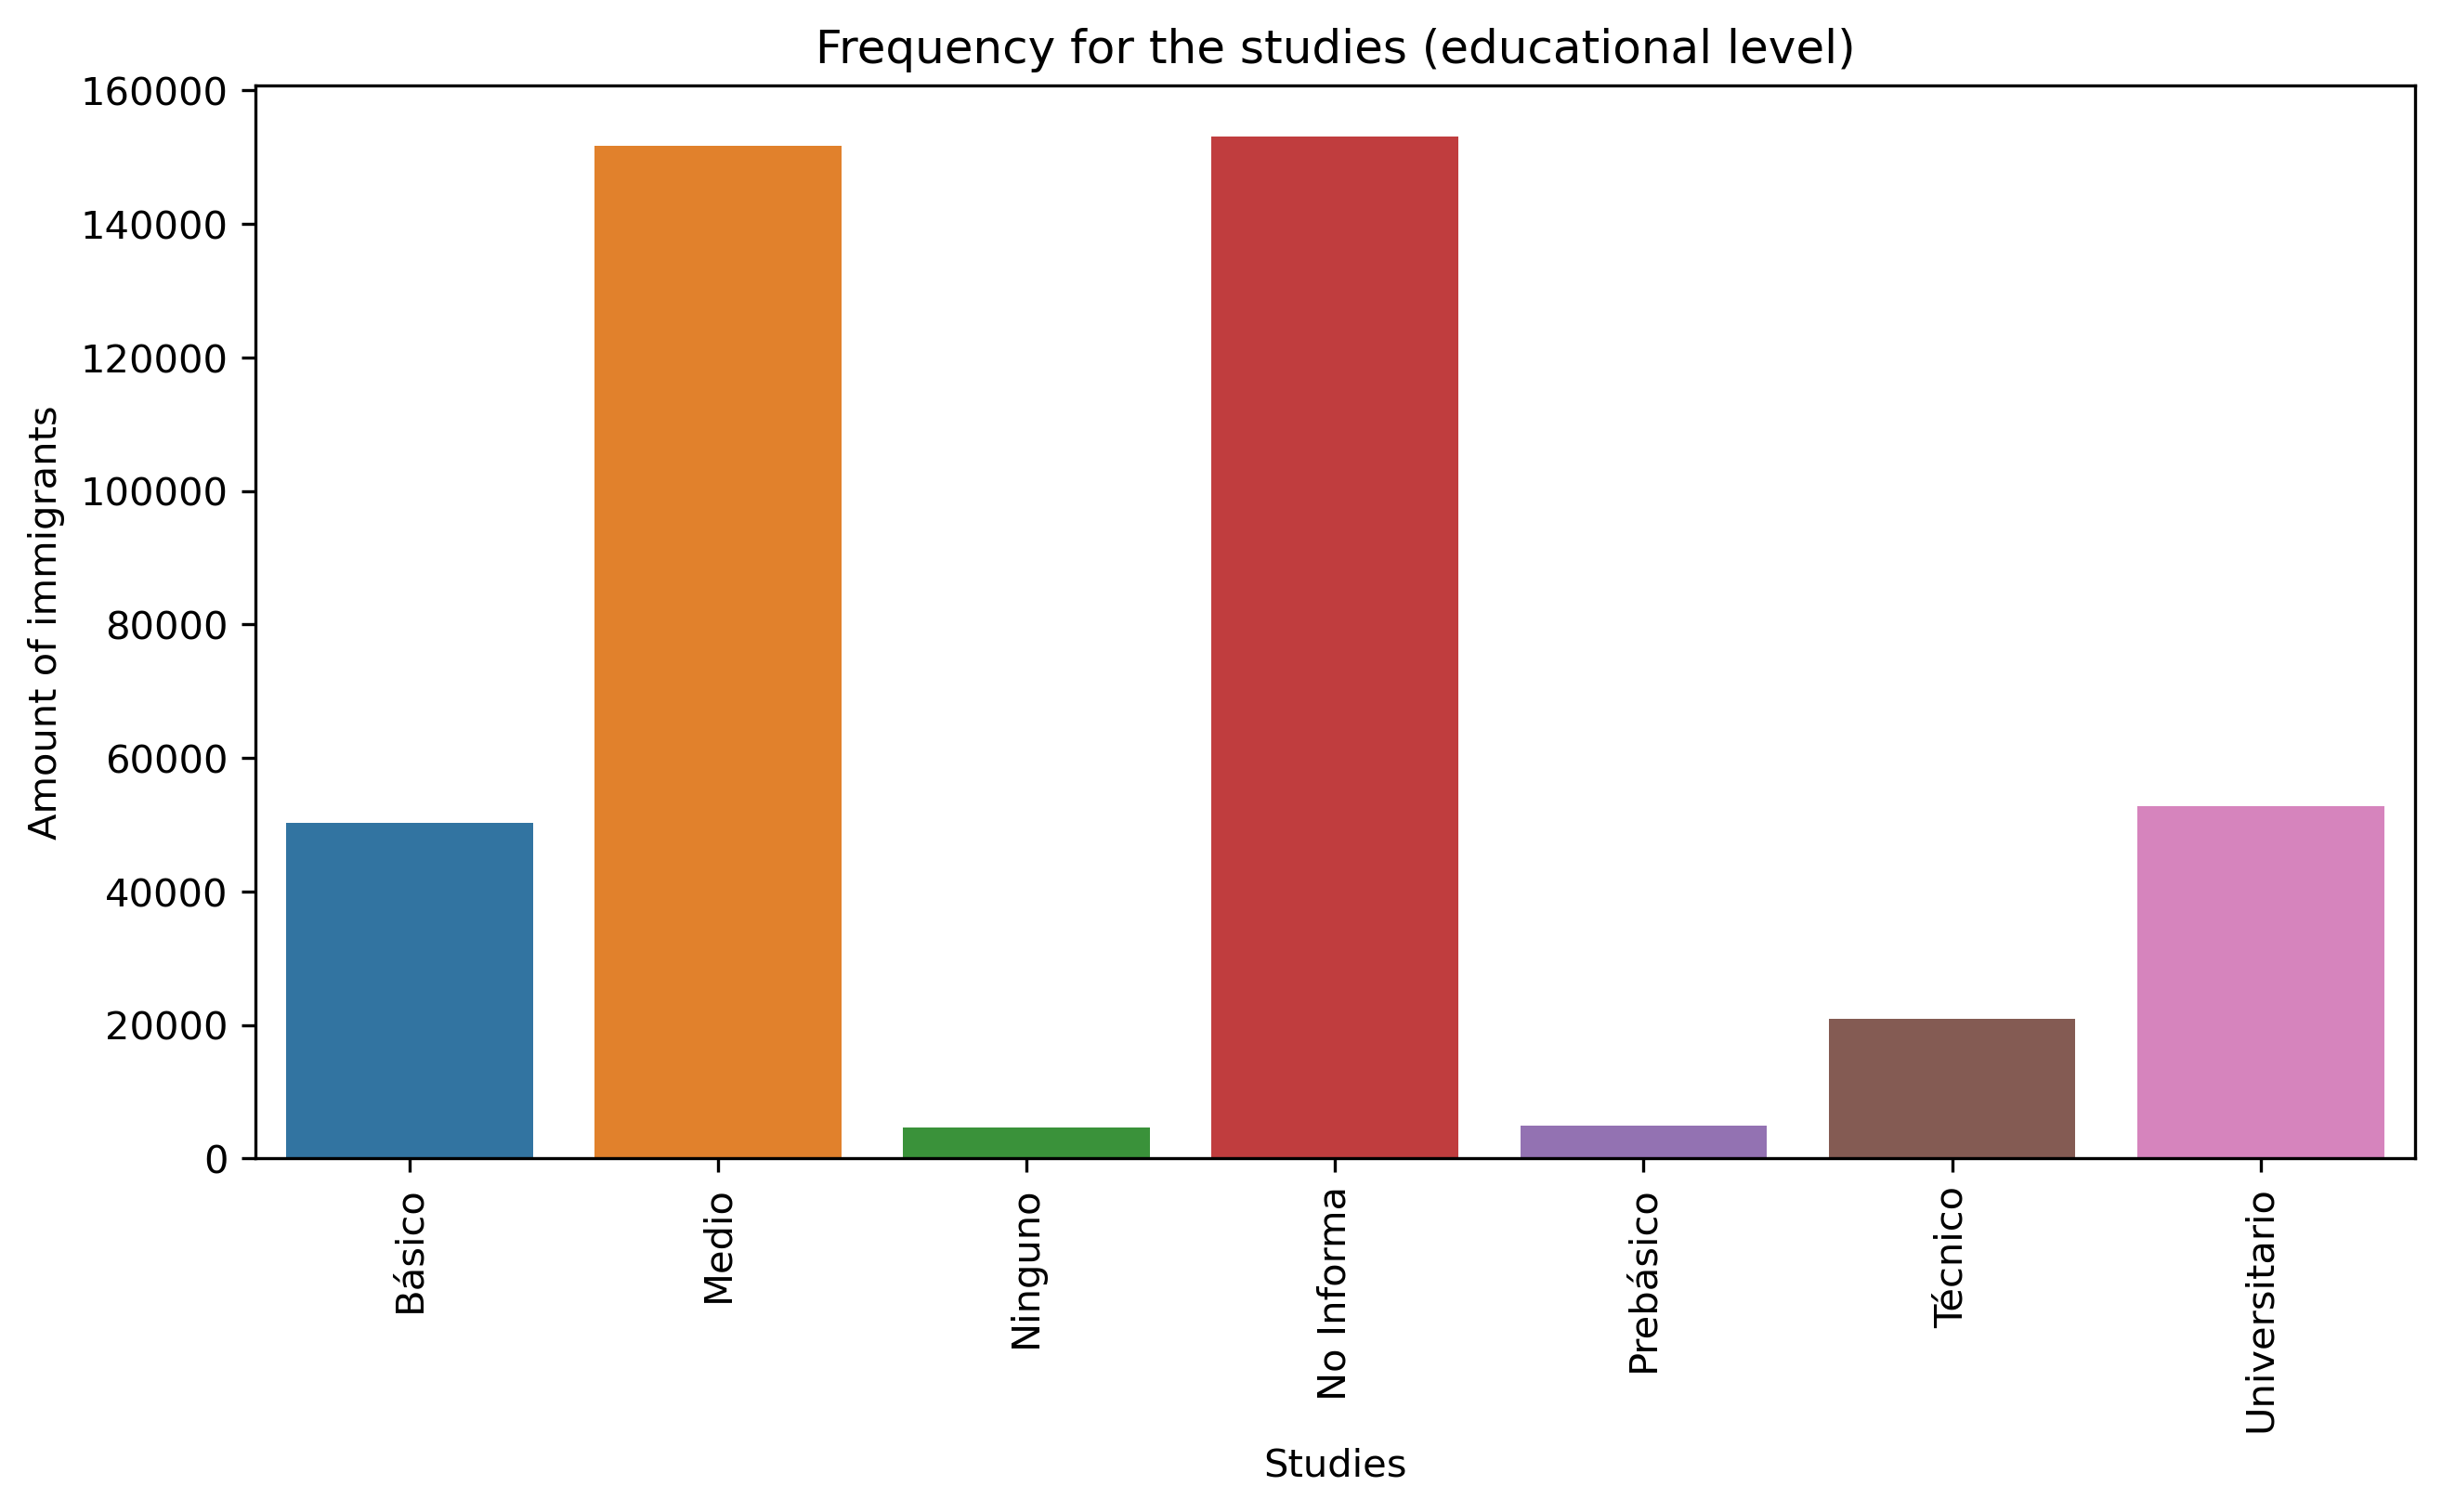

In [243]:
# Create frequency bar plot for the educational levels
ax = sns.countplot(x=df.studies)
plt.title("Frequency of study levels (educational level)")
plt.xlabel("Studies")
plt.ylabel("Amount of immigrants")
plt.xticks(rotation=90)
# plt.yscale('log')     # might not seem that useful at first, but helps to see the distributions
plt.show()

In [244]:
# Print frequencies for educational levels
df.groupby('studies').size()

studies
Básico            50294
Medio            151649
Ninguno            4627
No Informa       153069
Prebásico          4854
Técnico           20909
Universitario     52830
dtype: int64

At first glance, only a few percent seem to not have any kind of education (~1.1%). However people without any education, might also try to boost their chances for acceptance of their visa by not specifying their educational level - hence _no informa_ is actually the most frequent educational level in this data set (34.9%). Therefore, any assumption about the educational level has to be taken carefully as it might not represent the data properly.

#### Community

This column contains the communities where an immigrant went after coming to Chile. As there are 341 different communities, a histogram is again not useful (there seem to be no immigrants in 7 of the 348 Chilean communities). Consequently, the data is presented as the data for the professions. This means the first ten and last ten entries based on their frequencies and the mean, median, standard deviation, min and max value of all frequencies are printed. This helps to decide if a further inspection is useful.

In [256]:
# Print stats about frequencies
df.groupby('community').size().aggregate(['mean', 'median', 'std', 'min', 'max'])

mean       1285.137830
median      176.000000
std        3914.182596
min           1.000000
max       59386.000000
dtype: float64

In [257]:
# Also interesting to see the data in a log scaled fashion to get rid of some 'outlier' effects
df.groupby('community').size().apply(np.log).aggregate(['mean', 'median', 'std', 'min', 'max'])

mean       5.236963
median     5.170484
std        2.166565
min        0.000000
max       10.991814
dtype: float64

#### State

The state column represents the 56 provinces to which the immigrants went after coming to Chile. As shown by the data, there have been immigrants in all provinces in Chile.
Regarding the visualisation of the data, this time there are few enough provinces that they can also be analysed in a histogram.

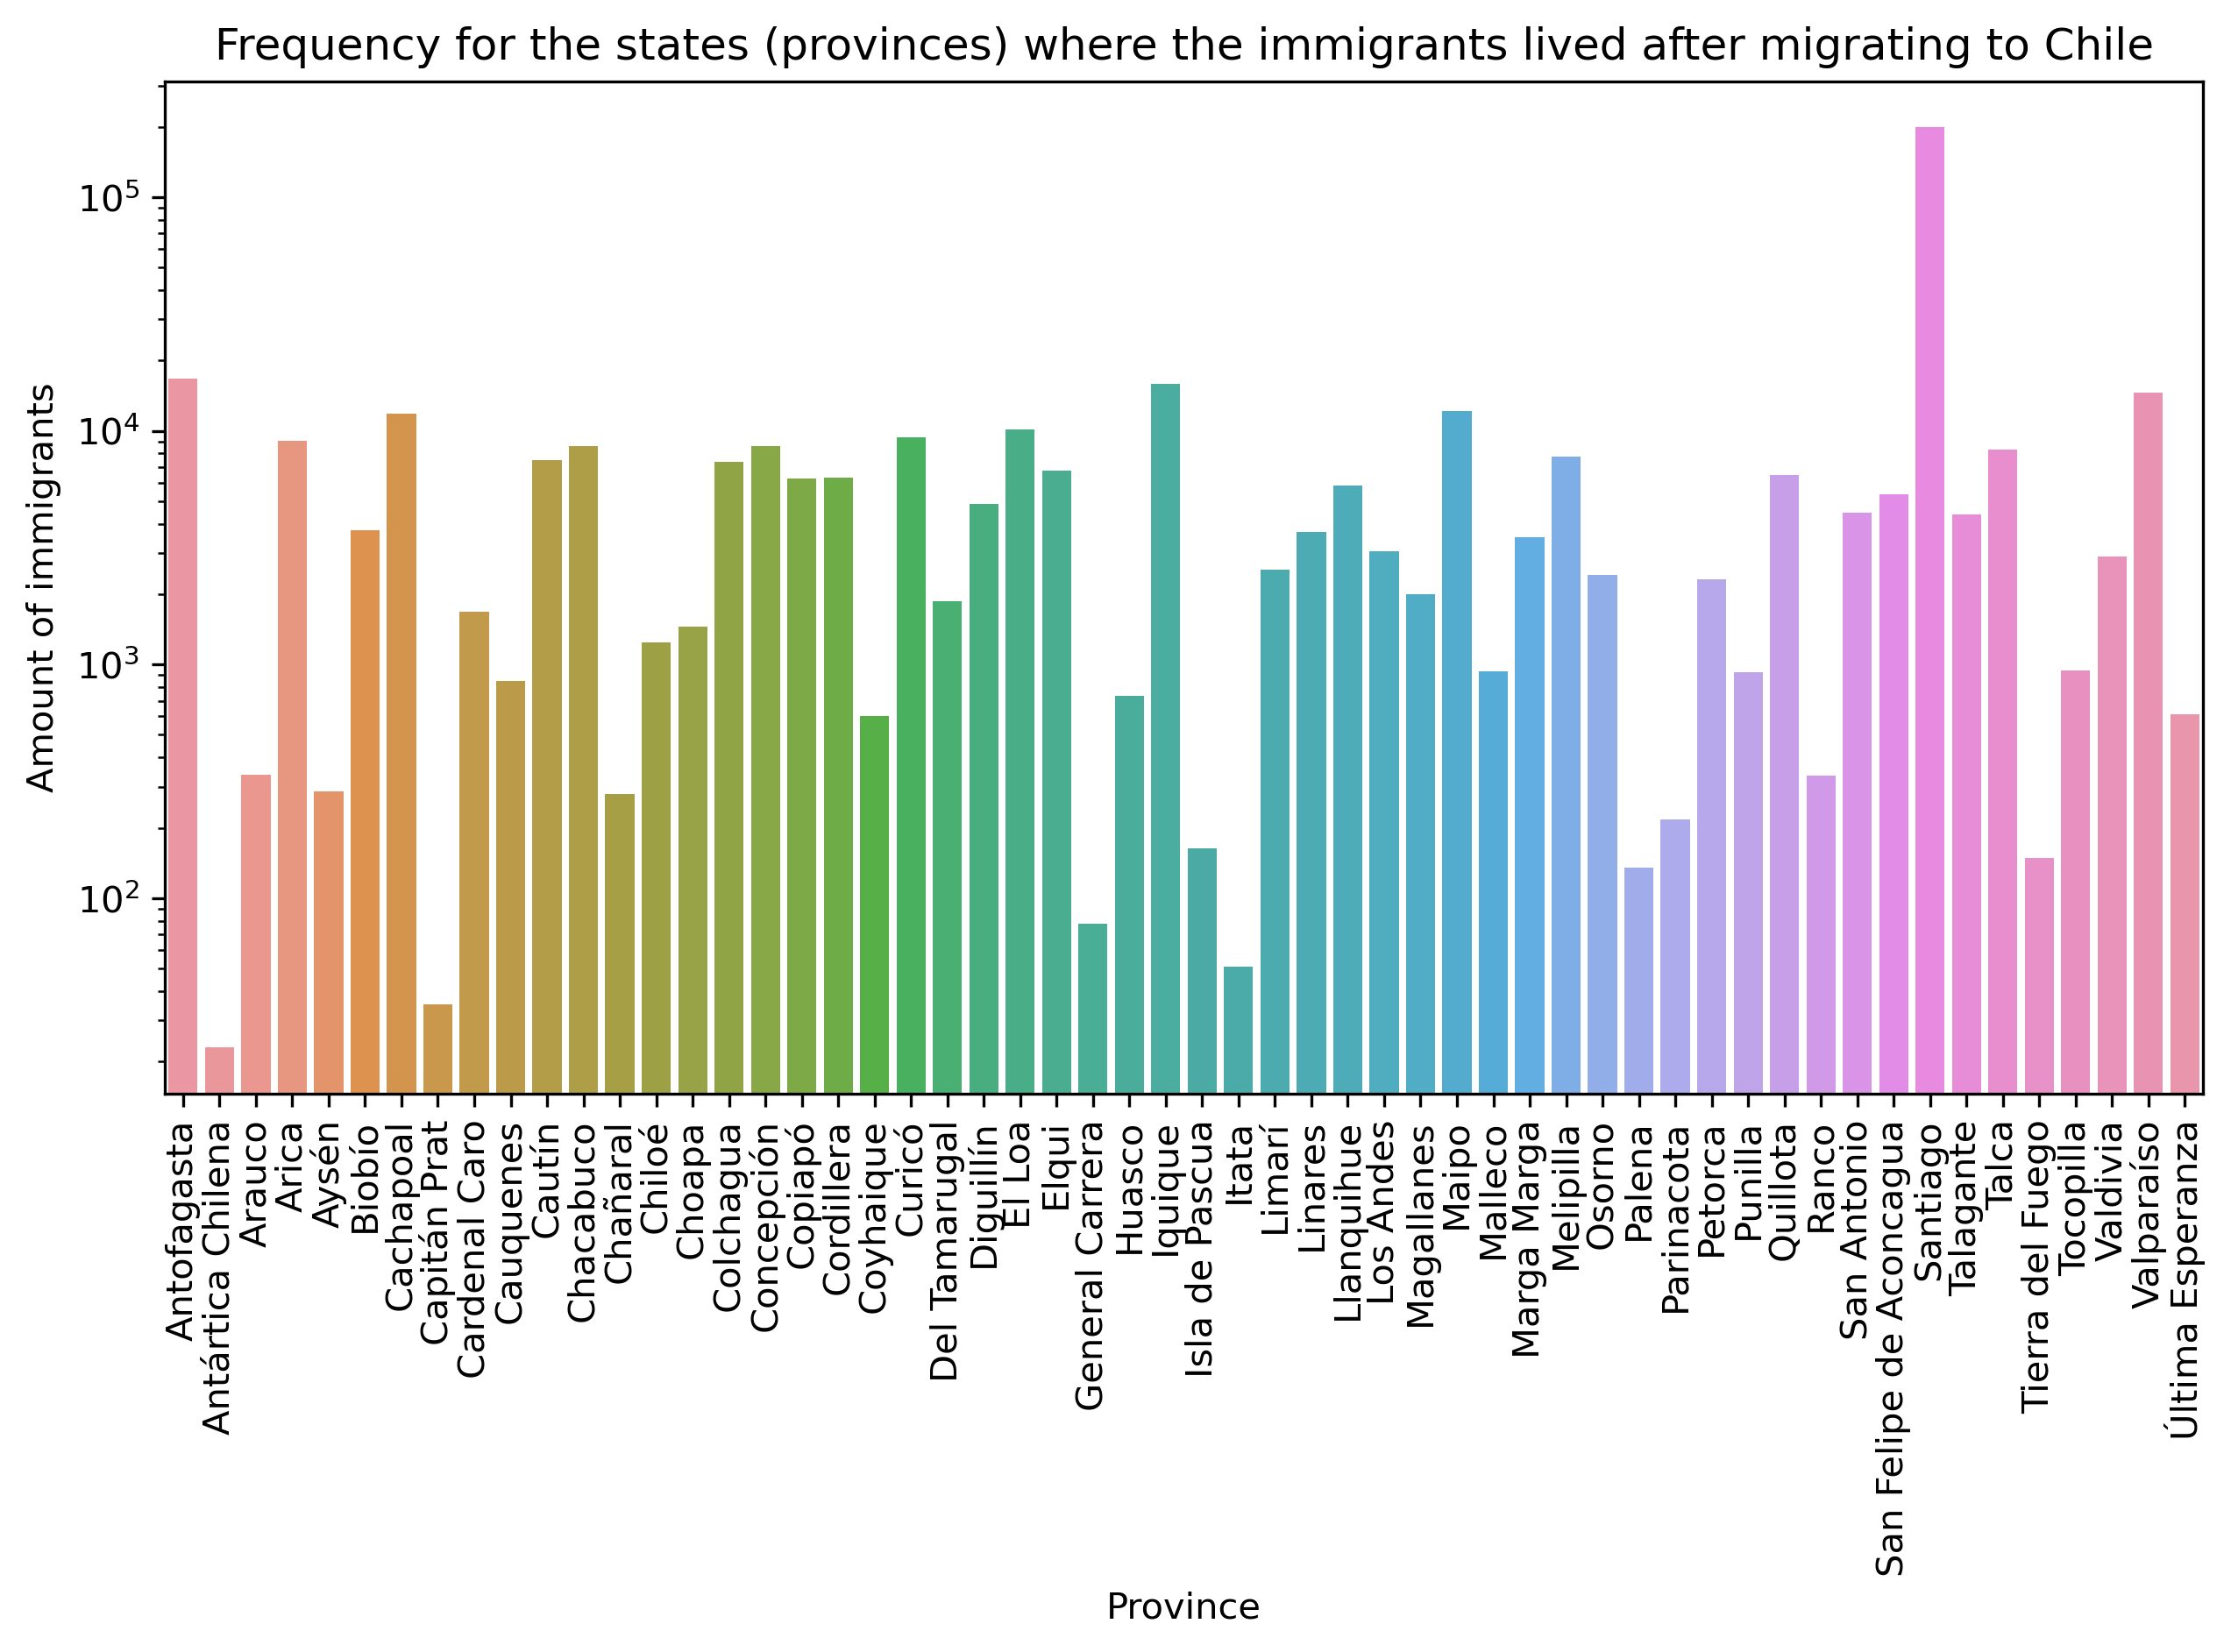

In [265]:
# Creating histogram for the states (provinces)
sns.countplot(x=df.state)
plt.title("Frequency of the states (provinces) where the immigrants lived after migrating to Chile")
plt.xlabel("Province")
plt.ylabel("Amount of immigrants")
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

Obviously, by far the most immigrants move to Santiago de Chile. Santiago is the backbone of the Chilean economy and by far the most people live in this area. Therefore, it is also most attractive to immigrants - in great contrast to the Antártica for instance.
As the count for this region is magnitudes bigger, it is useful to scale the y-axis by a log scale.

In [266]:
# Print absolute frequencies
province_size = df.groupby(['state']).size()
province_size['total'] = len(df)
province_size

state
Antofagasta                 16717
Antártica Chilena              23
Arauco                        338
Arica                        9062
Aysén                         286
Biobío                       3761
Cachapoal                   11864
Capitán Prat                   35
Cardenal Caro                1685
Cauquenes                     850
Cautín                       7520
Chacabuco                    8585
Chañaral                      279
Chiloé                       1241
Choapa                       1448
Colchagua                    7386
Concepción                   8611
Copiapó                      6245
Cordillera                   6326
Coyhaique                     602
Curicó                       9344
Del Tamarugal                1871
Diguillín                    4864
El Loa                      10119
Elqui                        6774
General Carrera                78
Huasco                        735
Iquique                     15910
Isla de Pascua                163
Itata   

#### Region

This column represents the region of immigration. All 16 of 16 regions of Chile received immigrants coming to the country in 2018. Due to the reduced size, again, the histogram plot is also possible again.

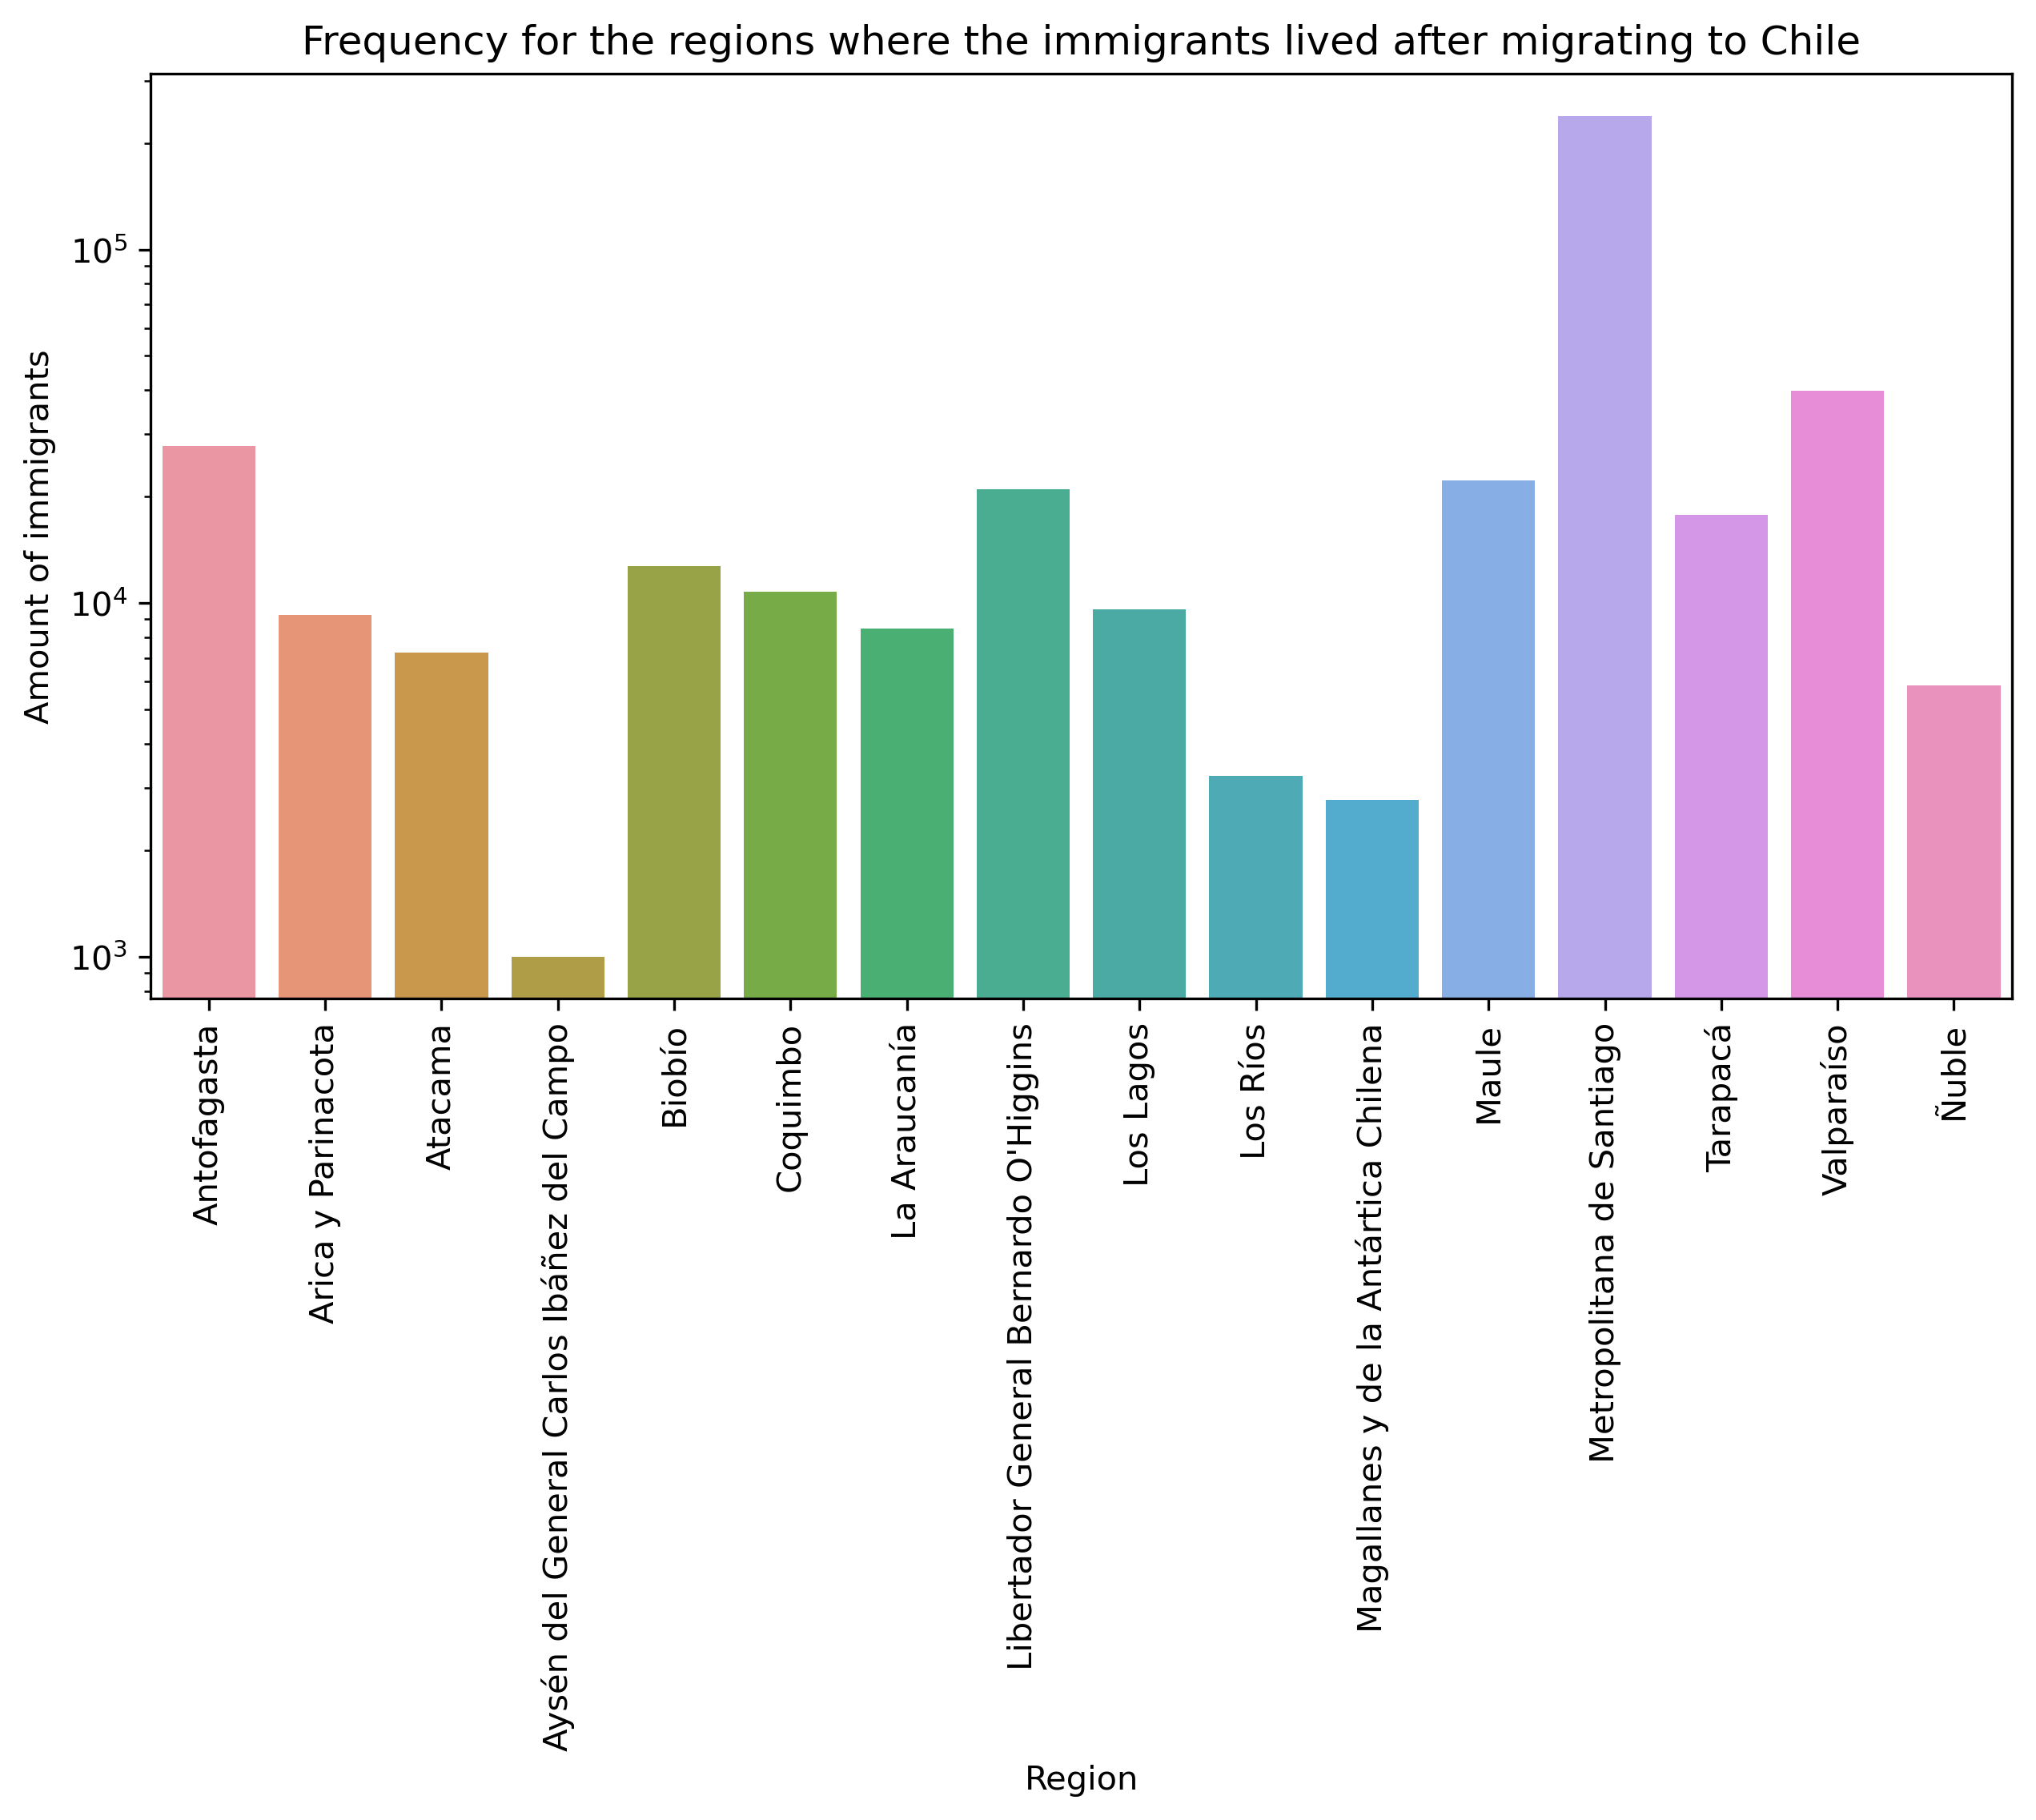

In [274]:
# Creating histogram for the states (provinces)
ax = sns.countplot(x=df.region)
plt.title("Frequency of the regions where the immigrants lived after migrating to Chile")
plt.xlabel("Region")
plt.ylabel("Amount of immigrants")
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

Again, by far the most immigrants came to the Metropolitan area of Santiago. Due to the massive differences in the frequencies, a log scale has been applied again to the y-axis.

In [275]:
# Print absolute frequencies
region_size = df.groupby(['region']).size()
region_size['total'] = len(df)
region_size

region
Antofagasta                                   27780
Arica y Parinacota                             9279
Atacama                                        7259
Aysén del General Carlos Ibáñez del Campo      1001
Biobío                                        12710
Coquimbo                                      10765
La Araucanía                                   8455
Libertador General Bernardo O'Higgins         20935
Los Lagos                                      9605
Los Ríos                                       3242
Magallanes y de la Antártica Chilena           2783
Maule                                         22225
Metropolitana de Santiago                    238654
Tarapacá                                      17781
Valparaíso                                    39914
Ñuble                                          5844
total                                        438232
dtype: int64

#### Visa Reason

This column represents the reason for the visa given in the application. There are 7 possible visa reasons, meaning they can again be represented in a histogram.

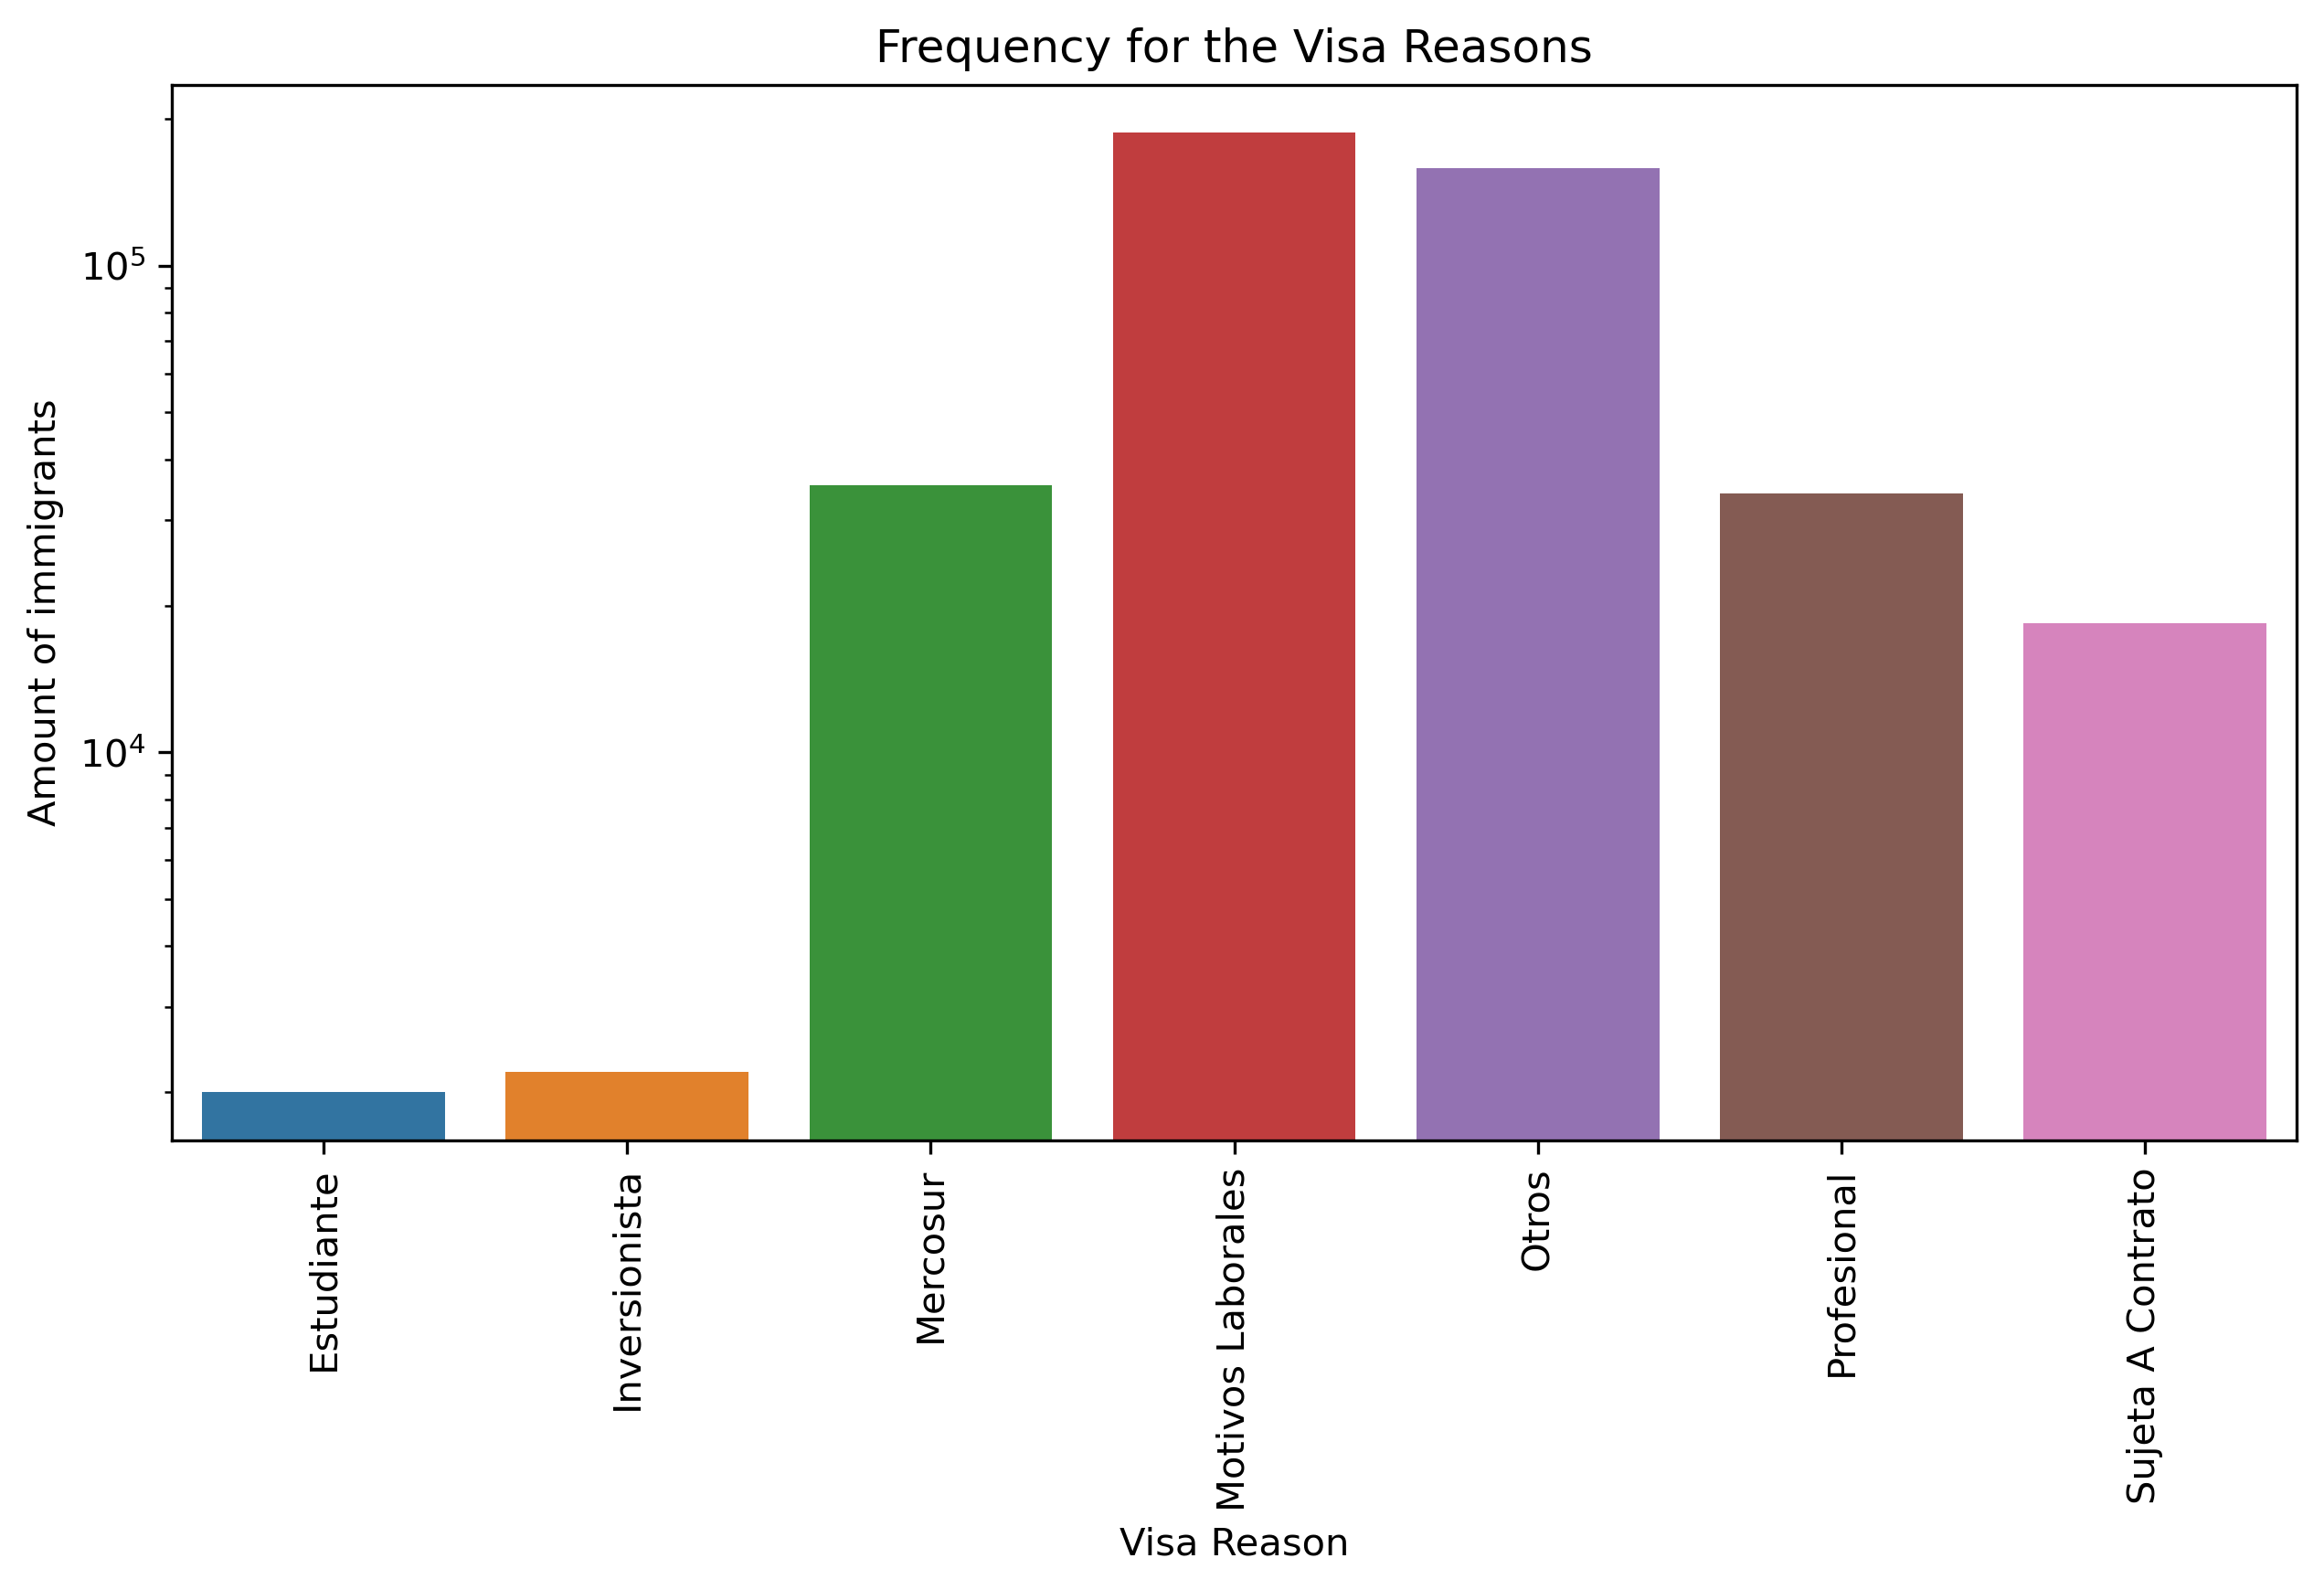

In [280]:
# Creating histogram for the states (provinces)
ax = sns.countplot(x=df.visa_reason)
plt.title("Frequency of the Visa Reasons")
plt.xlabel("Visa Reason")
plt.ylabel("Amount of immigrants")
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

In [281]:
# Print absolute frequencies
visa_reason_size = df.groupby(['visa_reason']).size()
visa_reason_size['total'] = len(df)
visa_reason_size

visa_reason
Estudiante             2001
Inversionista          2200
Mercosur              35400
Motivos Laborales    187524
Otros                158719
Profesional           34009
Sujeta A Contrato     18379
total                438232
dtype: int64

As students usually study between 3 and 5 years until they finish their academic career, a low rate of student visa is expected - it only applies for 3 to 5 years out of the average 75-80 years of average lifespan. Attracting international investors is also not easy due to the limited amount of wealthy people in the world. These 2 outliers should therefore be expected.

#### Month

This data field represents the month in which the related immigrant came to Chile. It is expressed as a number, the number of the month. January is therefore 1, February 2, and so on. As this is more of a categorical data field, the box plot is misleading in this case. Therefore, a more suitable bar plot is chosen visualizing the frequency of each of the values.

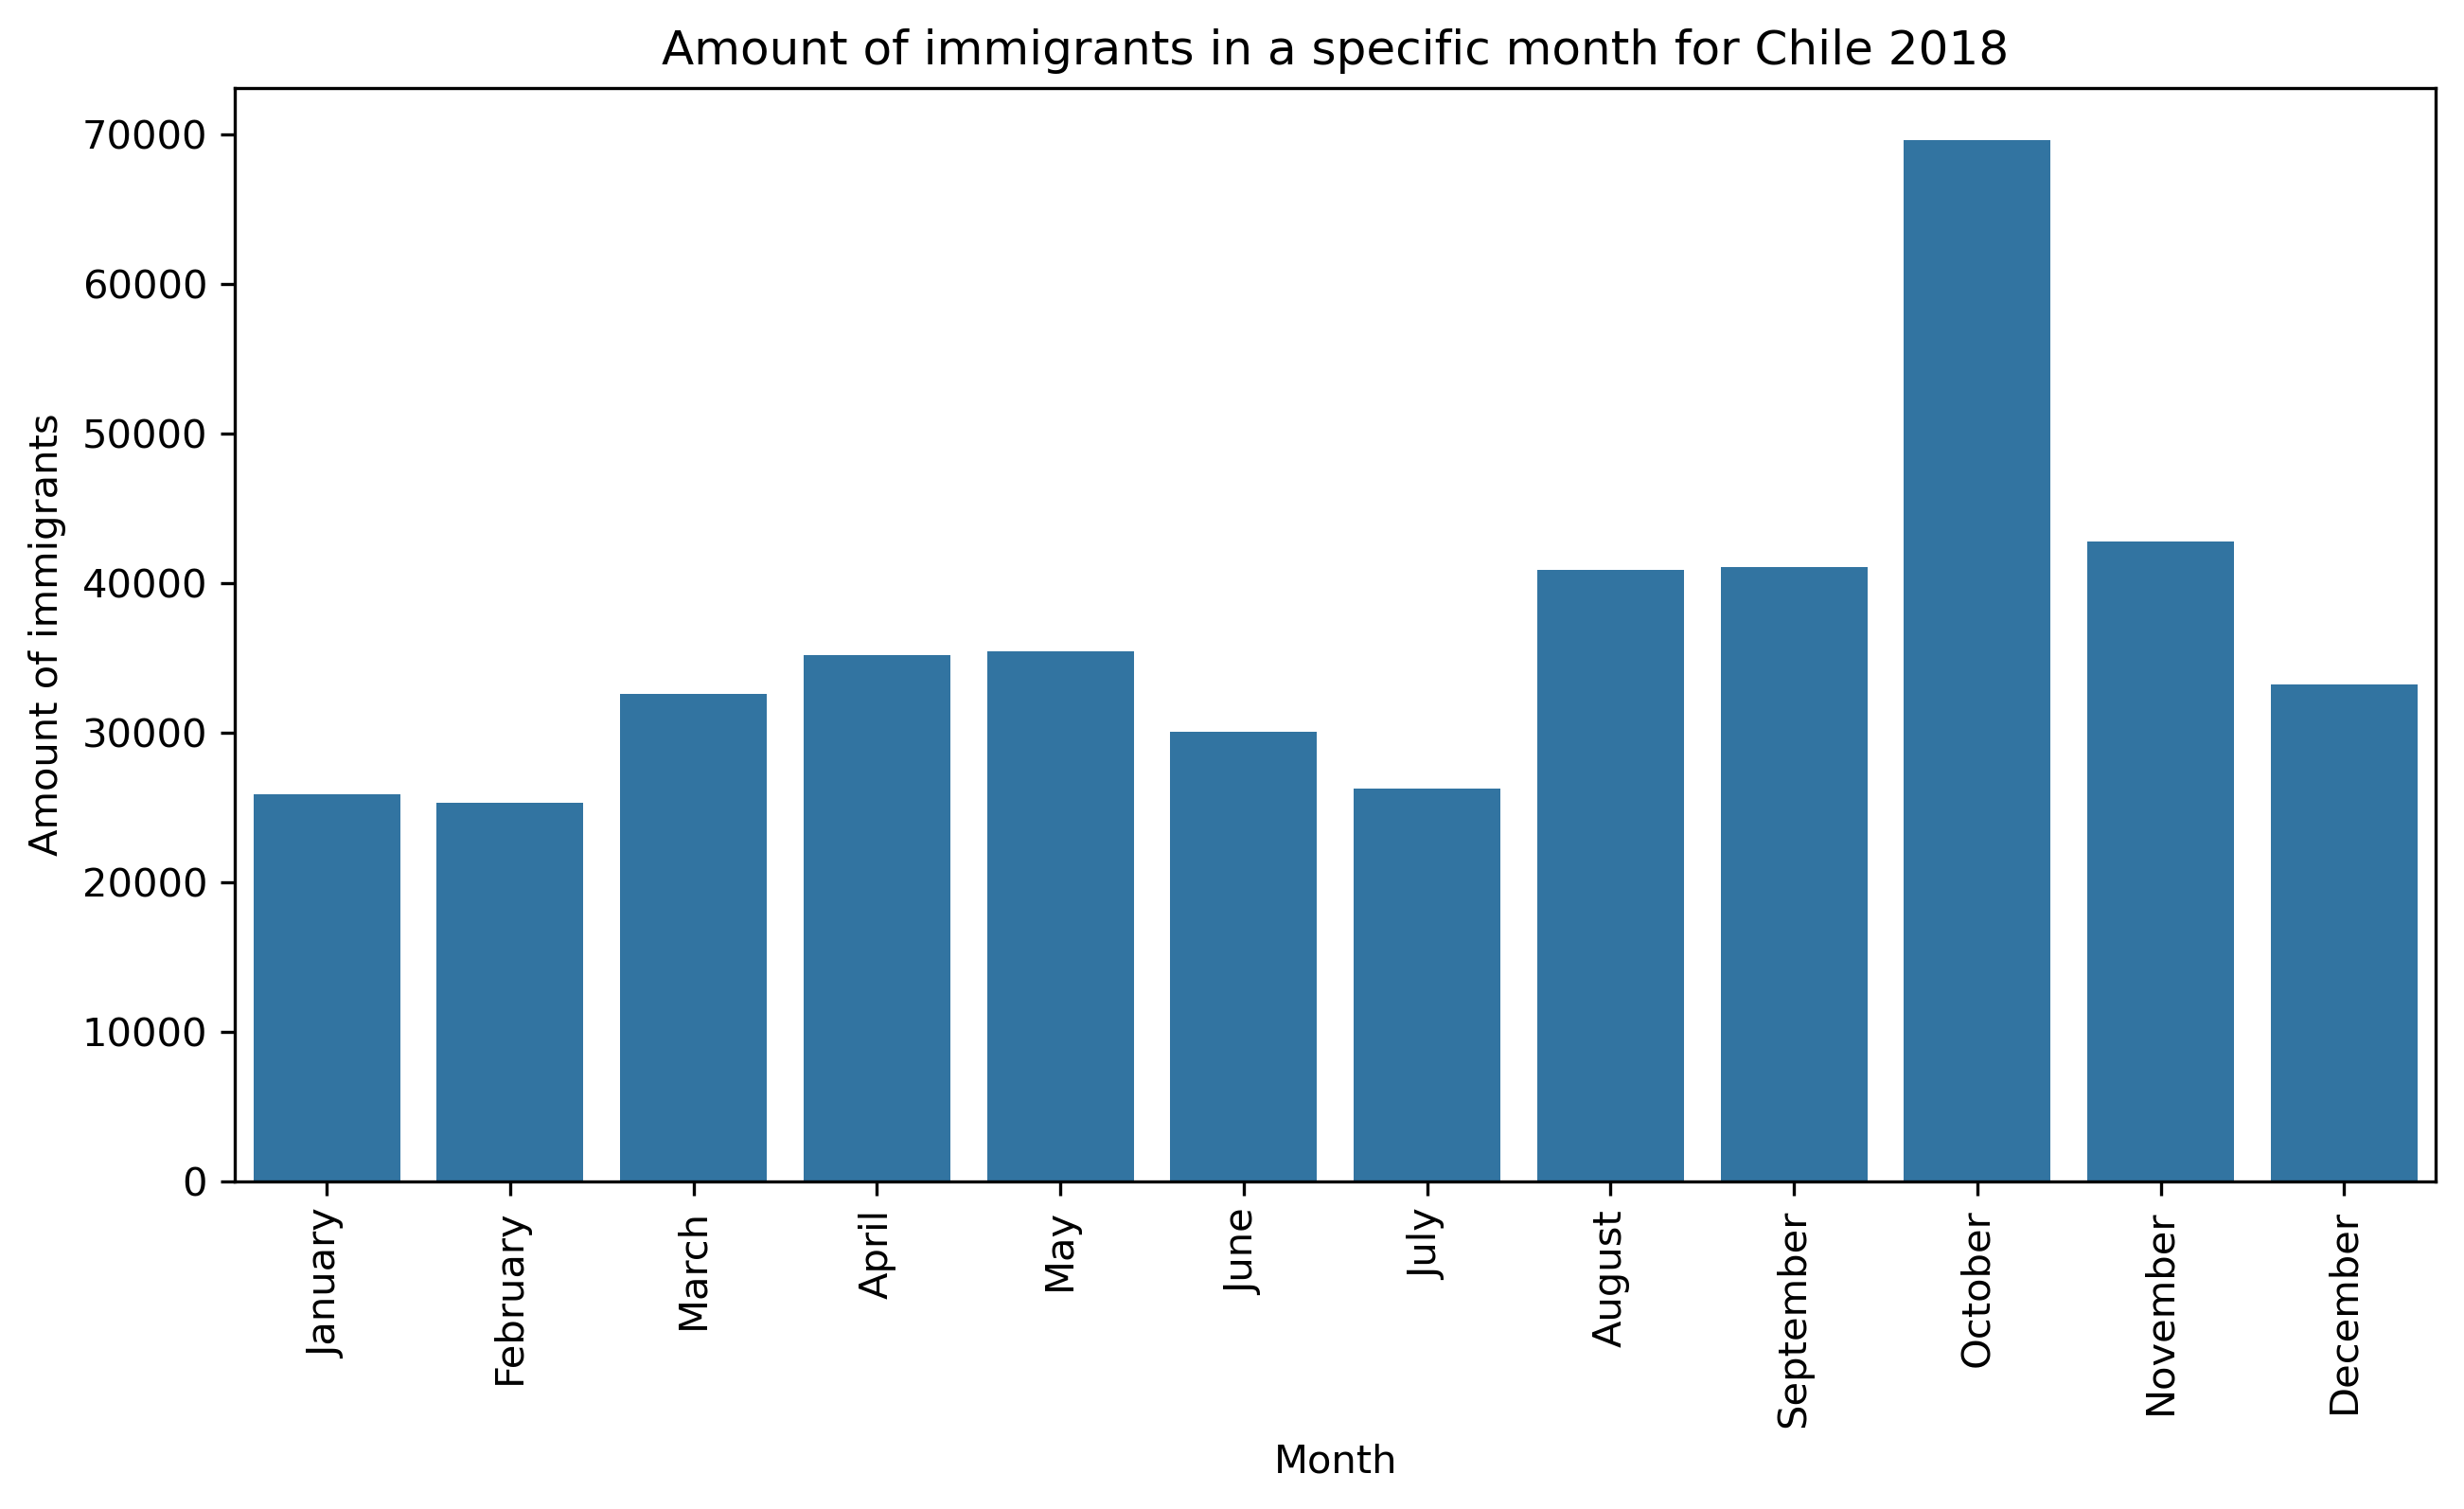

In [63]:
# Create frequency bar plot for the month
ax = sns.countplot(x=df.month, color='tab:blue')
plt.title("Amount of immigrants in a specific month for Chile 2018")
plt.xlabel("Month")
plt.ylabel("Amount of immigrants")
plt.xticks(rotation=90)
ax.set_xticklabels(list(map(lambda i: calendar.month_name[i + 1], range(0, 12))))
plt.show()

As there does not appear to be a reasonable explanation for the sudden rise in the data for october (there do not seem to be changes on the Chilean side like a new law), this outlier has to be examined for each country, separately.
The overall seasonal effects can be explained by the working seasons. Students only come in the beginning of a semester, and overall, after each holiday season (coupled with the students holidays), after a small amount of time the lack of working force might be noted. Therefore, guest workers are invited into the country.

In [282]:
# Print absolute frequencies
visa_reason_size = df.groupby(['month']).size()
visa_reason_size['total'] = len(df)
visa_reason_size

month
1         25873
2         25313
3         32591
4         35155
5         35418
6         30049
7         26250
8         40907
9         41071
10        69636
11        42755
12        33214
total    438232
dtype: int64

### Datetime columns

In this dataset there is just one column of the datetime data type, the birthday column. Analysing this column might not seem all that relevant, but allows for some statistics about the overall age distribution and about people sharing the same birthday in the same group.

#### Birthday

The analysing of the birthdays is no priority at first, it can merely be seen as a fun statistics example of the distribution of the birthday days in a year and how they are mostly equally distributed with some seasonal differences. The only real outlier should be February, the 29th, as this date is only possible once every 4 years.

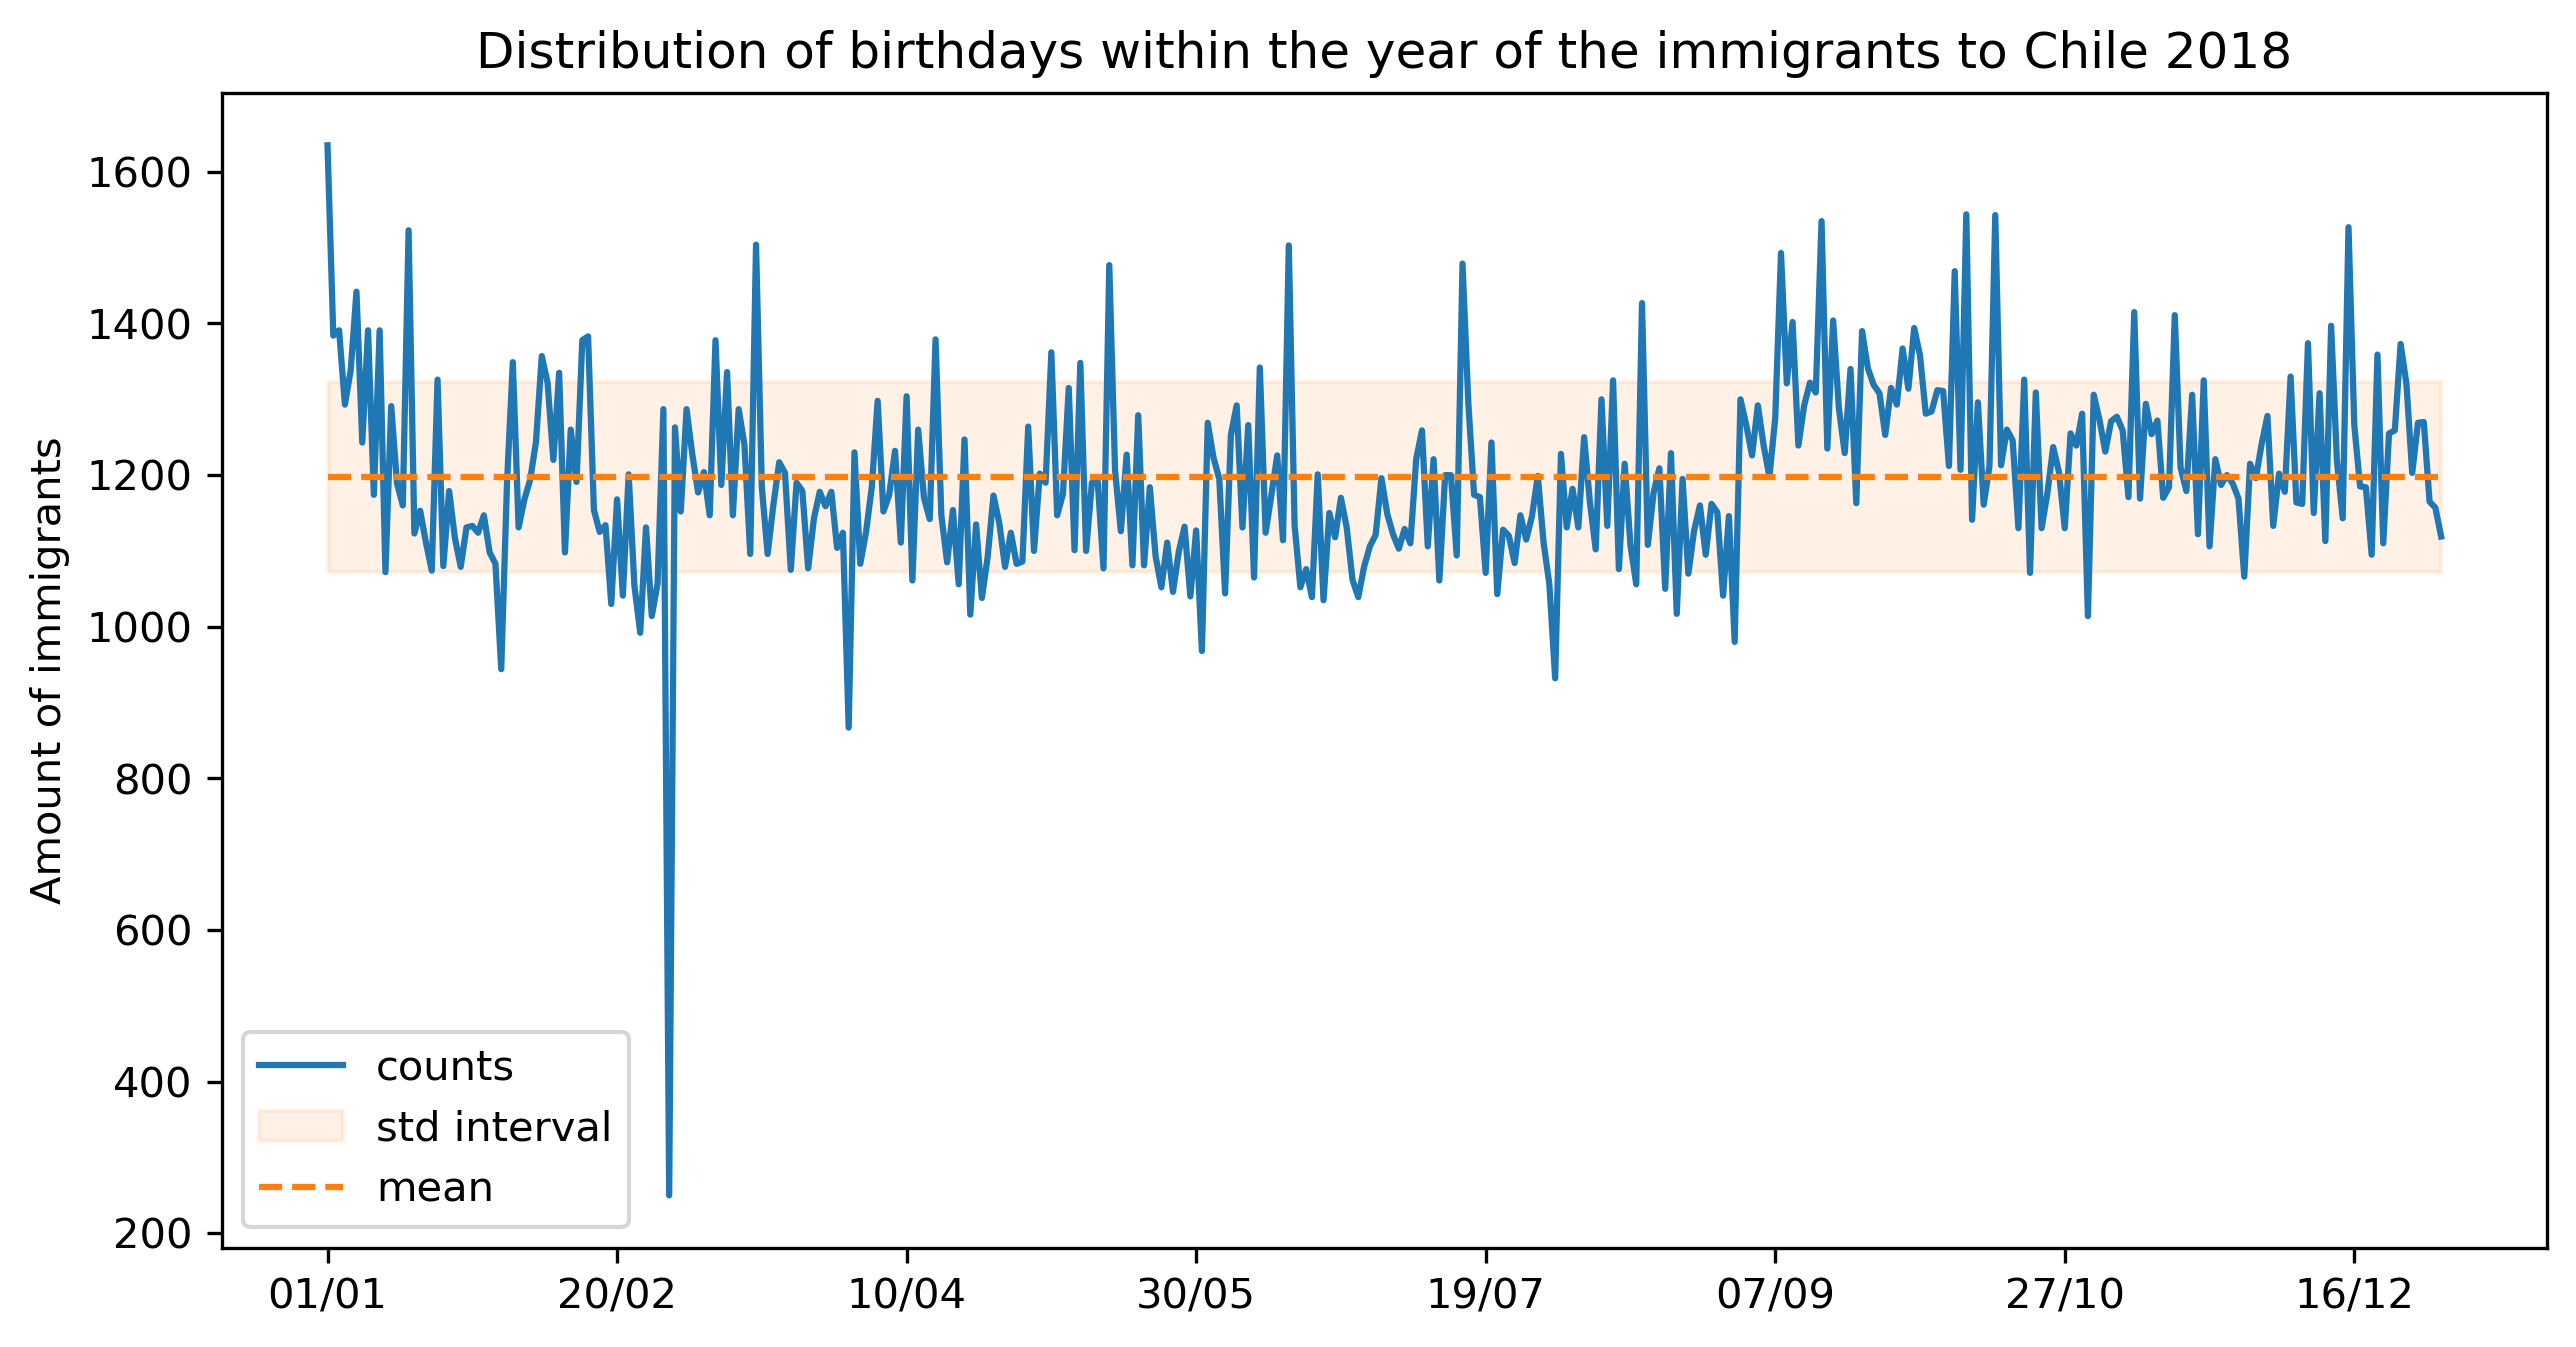

In [441]:
# Plot frequency of the birthdays (days of year)
birthday_series = df.birthday[df.birthday.notnull()].apply(lambda x: datetime(year=2020, month=x.month, day=x.day))
birthday_counts = birthday_series.value_counts()

birthday_df = pd.DataFrame({'counts': birthday_counts.values}, index=birthday_counts.index)
birthday_df.sort_index(inplace=True)

mean = birthday_df.counts.mean()
std = birthday_df.counts.std()

birthday_df.index = birthday_df.index.map(lambda x: x.strftime('%d/%m'))
birthday_df.plot.line()
plt.fill_between(birthday_df.index, mean - std, mean + std, alpha=0.1, color='tab:orange', label="std interval")
plt.plot(birthday_df.index, [mean for _ in range(len(birthday_df))], ls='--', label="mean")

plt.title("Distribution of birthdays within the year of the immigrants to Chile 2018")
plt.ylabel("Amount of immigrants")
plt.legend(loc='best')
plt.show()

In [443]:
# Also interesting to see the data in a log scaled fashion to get rid of some 'outlier' effects
birthday_df.counts.aggregate(['mean', 'median', 'std', 'min', 'max'])

mean      1197.352459
median    1184.000000
std        125.388443
min        250.000000
max       1635.000000
Name: counts, dtype: float64

In [444]:
# Print the 10 most frequent elements
birthday_size = birthday_df.counts

birthday_freq = np.sort(birthday_size.to_numpy())
birthday_size[birthday_size.isin(birthday_freq[-10:])].sort_values(ascending=False)

01/01    1635
10/10    1544
15/10    1543
15/09    1535
15/12    1527
15/01    1523
15/03    1504
15/06    1503
08/09    1493
15/07    1479
Name: counts, dtype: int64

In [445]:
# Print the 10 least frequent elements (needs 10 most frequent elements already executed)
birthday_size[birthday_size.isin(birthday_freq[:10])].sort_values()

29/02     250
31/03     867
31/07     932
31/01     944
31/05     968
31/08     980
24/02     992
26/02    1014
31/10    1014
21/04    1016
Name: counts, dtype: int64

Indeed, February, the 29th is a real outlier (the only one). Scaling this value with 4 however shows, that this date fits the seasonal data of February quite well.